In this notebook I use a neural network to classify galaxies with their images. Here there two types of galaxies (spiral and ellipticals) and no other objects.

I now import the needed libraries 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression

Below I get the data, which is produced by the program get_zoo_galaxies.py.  The is applied  43 times and thus gets data from 43 fields. This fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in Declination. 

The data consist of two pieces, firstly the images, which were saved as 4 dimensions (1 dimension x of image, second y of image, third channels, forth image in order or batch on torch language) numpy arrays, because torch needs 4d arrays, even when as here only a single channel exist. The image are rdeep images from http://research.iac.es/proyecto/stripe82/pages/data.php
This channel is the channel combination with the highest snr. Secondly information on each iamges is loaded as data frame, that are in particular the calseses spiral and elliptical which are bollean and exclusive here. There are citizen zoo classifications from the zoo projects. Only rather certain ones I included here, but there is no 100% certainty. 

In [2]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
print(list_images)
#ggeti9ng the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()
print(list_tables)

['stripe82_01_ell_spiral_im.npy', 'stripe82_02_ell_spiral_im.npy', 'stripe82_03_ell_spiral_im.npy', 'stripe82_04_ell_spiral_im.npy', 'stripe82_05_ell_spiral_im.npy', 'stripe82_06_ell_spiral_im.npy', 'stripe82_07_ell_spiral_im.npy', 'stripe82_08_ell_spiral_im.npy', 'stripe82_09_ell_spiral_im.npy', 'stripe82_10_ell_spiral_im.npy', 'stripe82_11_ell_spiral_im.npy', 'stripe82_12_ell_spiral_im.npy', 'stripe82_13_ell_spiral_im.npy', 'stripe82_14_ell_spiral_im.npy', 'stripe82_15_ell_spiral_im.npy', 'stripe82_16_ell_spiral_im.npy', 'stripe82_17_ell_spiral_im.npy', 'stripe82_18_ell_spiral_im.npy', 'stripe82_19_ell_spiral_im.npy', 'stripe82_20_ell_spiral_im.npy', 'stripe82_21_ell_spiral_im.npy', 'stripe82_22_ell_spiral_im.npy', 'stripe82_23_ell_spiral_im.npy', 'stripe82_24_ell_spiral_im.npy', 'stripe82_25_ell_spiral_im.npy', 'stripe82_26_ell_spiral_im.npy', 'stripe82_27_ell_spiral_im.npy', 'stripe82_28_ell_spiral_im.npy', 'stripe82_29_ell_spiral_im.npy', 'stripe82_30_ell_spiral_im.npy', 'stripe82

Now I built the function to combine the four numpy arrays.

In [3]:
#combines numpy arrays of 4d shape, same shape first 3, last variable
def comb_nump_4d(input_list):
    l=0
    for i in range(len(input_list)):
        a=np.load(input_list[i])
        l+=a.shape[3]
    combined=np.zeros((a.shape[0],a.shape[1],a.shape[2],l))
    l=0
    for i in range(len(input_list)):
        a=np.load(input_list[i])
        combined[:,:,:,l:l+a.shape[3]]=a
        l+=a.shape[3]  
    return combined

Next I combine the images. 

In [6]:
cutouts=comb_nump_4d(list_images)
print(cutouts.shape)

(43, 43, 1, 7875)


Now I combine the data frames with the classifications and more meta data. 

In [7]:
list_df=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}")    

number of tables is 43


In [8]:
df=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df.shape}")
print(f"shape of image file is {cutouts.shape}")

shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data has the same lengths. Now I am looking on classes. 

In [9]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


The classes are somewhat inbalanced, the ones which are not spiral are ellipticals. 
 
Next I add the image pixel information to the data frame, these data will be used by the algorithms which do not work on images but on tables. I Just run run two lopps within each other, thus the order is not particular meaningful. 

In [10]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)    
#there are warnings but it works 

/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

      Unnamed: 0  index                objid          ra       dec  psfMag_u  \
0              0      1  1237663237128388701   50.130513 -1.228488  22.01211   
1              1    123  1237666299481817102   50.160628 -1.035026  19.01124   
2              2    140  1237663237128388949   50.167304 -1.241885  22.36878   
3              3    458  1237666300018557091   50.006004 -0.495751  21.98376   
4              4    110  1237663238739067202   50.387910  0.198944  21.86834   
...          ...    ...                  ...         ...       ...       ...   
7870         101    101  1237663543675126583  312.305638  0.325466  21.65428   
7871         102    243  1237663543675060734  312.252401  0.351028  21.40535   
7872         103    257  1237678596459004706  312.353091  0.906897  20.69301   
7873         104    263  1237678596459070093  312.482143  0.899587  20.42247   
7874         105      8  1237678617933840840  312.415661  0.836877  21.30678   

      psfMag_g  psfMag_r  psfMag_i  psf

/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=cutouts[i,j,0,:]
/tmp/ipykernel_8518/2079145615.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x]=

Next I am checking between which column numbers is the image pixel information. 

In [11]:
print(df.columns[51],df.columns[1899])

0 1848


Next I am splitting the data set into test and train. There are two feature variants, one is the standard tables for everything beisdes convolutional network and the other is the image data set for everything else. 

In [12]:
#images_test/train are feature for vonvolutional network 
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data is")
print(image_train.shape)

shape of image train data is
(4725, 1, 43, 43)


I start with not neural network methods for classification, first XGBoost,  in standard setting. 

In [13]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

In [14]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1238    1]
 [   0 3486]]
confusion matrix xgboost test
[[ 753  117]
 [ 116 2164]]


Xgboost works approximately with standard settings, only about a sevenmth is wrongly classified even in the rarer class. Likely it can be improved because the train set is perfectly classified and thus it is clearly overfitting. 

Now I try logistic. A really high number of iterations would be needed for convergence, scaling features would help, but since it is obvious that regularization is needed and that logistic is rather likely not ideal I ignore that here. 

In [15]:
lc1=LogisticRegression(max_iter=6000,penalty='none').fit(feature_train,target_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1205   34]
 [  20 3466]]
confusion matrix logistic regression test
[[ 478  392]
 [ 540 1740]]


Logistic works clearly less good as xgboost, test is clearly worse, the more rare class is only a little more often than to 50% right classified. Likely there is overfitting. For both should improve with regularization. I use l2 regularization as method, since it can be applied to most algorithms and the data set is not large enough that a multi parameter optimiations does not easily leads to random chance but not true optimzation.

First I define a function for xgbboost to try several in a loop and get quality measures for them.

In [41]:
#start
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

Below, I apply it, the results are saved, since running all takes time. 

In [42]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)
np.savetxt("xgb_43sets_gal-type_v1.txt",stats_xgb)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.49353212e-01 2.56598174e-03
  2.24211778e-01]
 [3.00000000e-04 1.00000000e+00 9.51422319e-01 2.45484942e-03
  2.22394796e-01]
 [1.00000000e-03 9.99856590e-01 9.48381452e-01 2.58556133e-03
  2.22074409e-01]
 [3.00000000e-03 1.00000000e+00 9.49901553e-01 2.57140657e-03
  2.22985242e-01]
 [1.00000000e-02 1.00000000e+00 9.49725576e-01 2.52495030e-03
  2.17790500e-01]
 [3.00000000e-02 9.99856590e-01 9.52234882e-01 2.57514407e-03
  2.19505732e-01]
 [1.00000000e-01 9.99856590e-01 9.

Next I define a function to do the regularization loop for logistic. 

In [16]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}") #does not always converge but are cases which are certainly not useful ones
        xc1=LogisticRegression(max_iter=10000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

Below I run it, again the results are saved, since it takes time too run.

In [48]:
regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
print(regs)
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))
np.savetxt("log_43sets_gal-type_v1.txt",stats_log)

[1e-10, 3e-09, 1e-08, 3e-08, 1e-07, 3e-07, 1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
doing l2 regularization 1e-10
doing l2 regularization 3e-09
doing l2 regularization 1e-08
doing l2 regularization 3e-08
doing l2 regularization 1e-07
doing l2 regularization 3e-07
doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 0.3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 1


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 3


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 10


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 30


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


doing l2 regularization 100
[[0.00000e+00 8.49290e-01 8.43020e-01 5.53090e-01 5.62540e-01]
 [0.00000e+00 8.66870e-01 8.60600e-01 4.75930e-01 4.89510e-01]
 [0.00000e+00 8.69120e-01 8.61830e-01 4.45890e-01 4.66340e-01]
 [0.00000e+00 8.67910e-01 8.57430e-01 4.29210e-01 4.56010e-01]
 [0.00000e+00 8.65360e-01 8.52830e-01 4.19210e-01 4.51130e-01]
 [0.00000e+00 8.66680e-01 8.53500e-01 4.13000e-01 4.49790e-01]
 [0.00000e+00 8.67930e-01 8.49400e-01 4.07050e-01 4.53330e-01]
 [0.00000e+00 8.70310e-01 8.46850e-01 4.00760e-01 4.63900e-01]
 [1.00000e-05 8.71310e-01 8.44620e-01 3.91520e-01 4.92460e-01]
 [3.00000e-05 8.76320e-01 8.45540e-01 3.80150e-01 5.30800e-01]
 [1.00000e-04 8.85370e-01 8.42300e-01 3.62930e-01 5.76390e-01]
 [3.00000e-04 8.94820e-01 8.44190e-01 3.39190e-01 6.03090e-01]
 [1.00000e-03 9.11470e-01 8.41570e-01 2.98990e-01 6.63140e-01]
 [3.00000e-03 9.32760e-01 8.39780e-01 2.51760e-01 7.81500e-01]
 [1.00000e-02 9.54470e-01 8.28860e-01 1.97970e-01 9.58160e-01]
 [3.00000e-02 9.67910e-01 8

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now plotting I plot measure for both, first f1 score. 

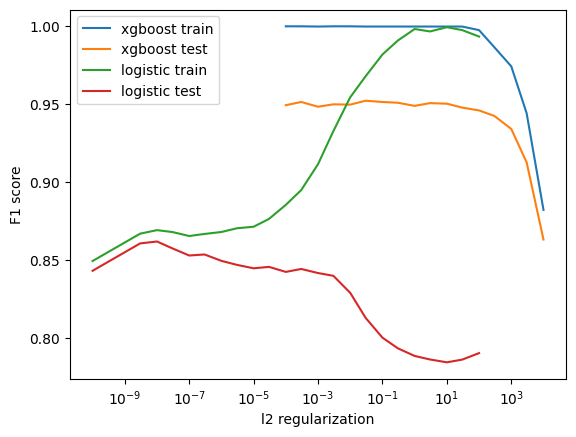

In [17]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

For xgboost train is perfect for many and over them the test score varies without clear maximum. Logistic looks different, there the best of test is clearly at a differnt regularization. 

Then I look on log loss. 

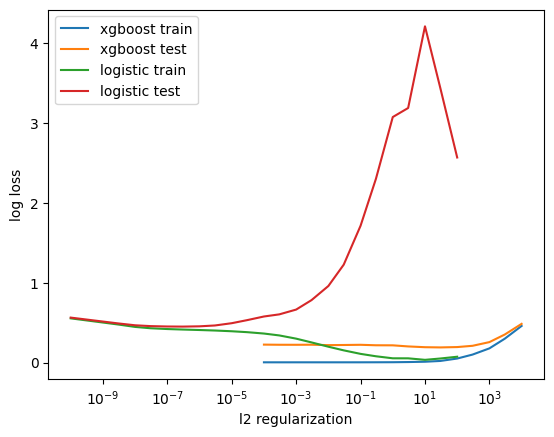

In [18]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")

Probably very bad  convergence causes change at high l for train for logistic, the small value at the highest numeric l2 regularization (is smallest in reality since invrese defined) is very likely caused by bad convergence, but since it is clearly not the best solution, I can ignore it. 

 Below I zoom into the better values for log loss to see whether there is a minimum.

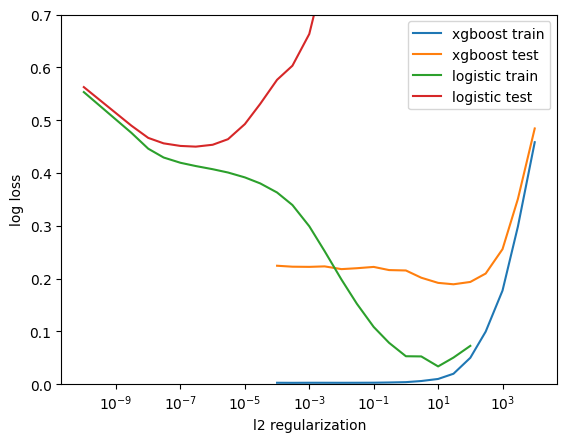

In [19]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.ylim(0,0.7)
plt.xscale("log")

There is now one also for xgboost. The minimum for linear is clearly worse. Thus linear is in all repsect worse than xgboost.

Now I start to look on neural networks. 

First I get the specific ready for torch neural networks. 

In [20]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


Next I define a class which gets the data ready for torch neural networks by adding feature and targets together. 

In [21]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

This is then applied below to both the data for cornvolutional network and for multilayer perceptron. The data frame data also needs to converted to numpy arrays first. 

In [22]:
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())


Next then data set is loaded again for both kind of networks. The mian kind of train uses the btach size which is defined here. For test and the oredicting variant of test applies to all data at once. 

In [23]:
BATCH_SIZE=32
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)

Next, I define a function to fit data with torch.

In [24]:
#parameters: model used m(need to be fined before), train_data, test_data, epochs, batch_size, 
#learning_rate, file for  collecting statistic, 
#optional regularization and whether  output is printed during running 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0,silent=False):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)  
    if silent==False:    
        print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
        if silent==False:
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Next I define the function to predict targets when a model is known.

In [25]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

Below I test the size of the outputs as function of the 43 \* 43 image input. The design uses 3*3 convolutions and 2\*2 max pooling. The step size is 1 to get all feature. There is no padding because the image does not really end at the end of the cutout.

In [27]:
input0 = torch.randn(1, 1, 43, 43)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first convolutional layer, input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output1 = m(output0)
print(f"first max pool layer: input:{output0.shape} output: {output1.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)

output2=b2(output1)
print(f"second convolutional layer, input: {output1.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer, input: {output2.shape} output: {output3.shape}")

b3=torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

output4=b3(output3)
print(f"third convolutional layer, input: {output3.shape} output: {output4.shape}")
output5 = m(output4)
print(f"third max pool layer, input: {output4.shape} output: {output5.shape}")

first convolutional layer, input: torch.Size([1, 1, 43, 43]) output: torch.Size([1, 16, 41, 41])
first max pool layer: input:torch.Size([1, 16, 41, 41]) output: torch.Size([1, 16, 20, 20])
second convolutional layer, input: torch.Size([1, 16, 20, 20]) output: torch.Size([1, 32, 18, 18])
second max pool layer, input: torch.Size([1, 32, 18, 18]) output: torch.Size([1, 32, 9, 9])
third convolutional layer, input: torch.Size([1, 32, 9, 9]) output: torch.Size([1, 64, 7, 7])
third max pool layer, input: torch.Size([1, 64, 7, 7]) output: torch.Size([1, 64, 3, 3])


After 3 layers the output is just 3 pixels, then all are combined. 
Below this is then defined as class.

In [29]:
class CNNBinary4(torch.nn.Module):
    def __init__(self):
        super(CNNBinary4, self).__init__()
        # L1 ImgIn shape=(?, 43, 43, 1)
        # Conv -> (?, 41, 41, 16)
        # Pool -> (?, 20, 20, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 20, 20, 16)
        # Conv      ->(?, 18, 18, 32)
        # Pool      ->(?, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 9, 9, 32)
        # Conv      ->(?, 7, 7, 64)
        # Pool      ->(?, 3, 3, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))        
        # L3 FC 3x3x64 inputs -> 128 outputs
        self.fc1 = torch.nn.Linear(3 * 3 * 64, 128, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 128 inputs -> 1 output
        self.fc2 = torch.nn.Linear(128, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) #dont forget to add/omit layer here
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))      #sigmoid because there only two classes  
        return out

Now I make a first run.

In [30]:
keep_prob=1
model2c =CNNBinary4()
model2c.to(device)
print(model2c)
loss_stats_st11c = {
    'train': [], 'test': []
}
torch_fit(model2c,train_im_loader,test_im_loader,40,32,0.001,loss_stats_st11c)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Begin training.


/tmp/ipykernel_8518/494503414.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.25077 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.22768 | Test Loss: 27.61905
Epoch 003: | Train Loss: 26.21662 | Test Loss: 27.61905
Epoch 004: | Train Loss: 26.22768 | Test Loss: 27.61905
Epoch 005: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 006: | Train Loss: 26.21662 | Test Loss: 27.61905
Epoch 007: | Train Loss: 26.19450 | Test Loss: 27.61905
Epoch 008: | Train Loss: 26.20556 | Test Loss: 27.61905
Epoch 009: | Train Loss: 26.19450 | Test Loss: 27.61905
Epoch 010: | Train Loss: 26.22768 | Test Loss: 27.61905
Epoch 011: | Train Loss: 26.20556 | Test Loss: 27.61905
Epoch 012: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 013: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 014: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 015: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 016: | Train Loss: 26.21662 | Test Loss: 27.61905
Epoch 017: | Train Loss: 26.21662 | Test Loss: 27.61905
Epoch 018: | Train Loss: 26.21662 | Test Loss: 2

It does not work (or only very slow) as I figured out many runs. Many many other attempts I tried with l2 regularization. 

In [31]:
keep_prob=1
model2c =CNNBinary4()
model2c.to(device)
print(model2c)
loss_stats_st11c = {
    'train': [], 'test': []
}
torch_fit(model2c,train_im_loader,test_im_loader,40,32,0.001,loss_stats_st11c,l2reg=0.3)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Begin training.


/tmp/ipykernel_8518/494503414.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 42.14380 | Test Loss: 27.61905
Epoch 002: | Train Loss: 10.36576 | Test Loss: 0.61829
Epoch 003: | Train Loss: 0.57409 | Test Loss: 0.48317
Epoch 004: | Train Loss: 0.52807 | Test Loss: 0.63990
Epoch 005: | Train Loss: 0.56139 | Test Loss: 0.63759
Epoch 006: | Train Loss: 0.49558 | Test Loss: 0.48452
Epoch 007: | Train Loss: 0.48382 | Test Loss: 0.44783
Epoch 008: | Train Loss: 0.48512 | Test Loss: 0.42483
Epoch 009: | Train Loss: 0.49187 | Test Loss: 0.43354
Epoch 010: | Train Loss: 0.47198 | Test Loss: 0.42133
Epoch 011: | Train Loss: 0.47687 | Test Loss: 0.54977
Epoch 012: | Train Loss: 0.48941 | Test Loss: 0.54692
Epoch 013: | Train Loss: 0.45032 | Test Loss: 0.43519
Epoch 014: | Train Loss: 0.48031 | Test Loss: 0.45297
Epoch 015: | Train Loss: 0.45755 | Test Loss: 0.44281
Epoch 016: | Train Loss: 0.46437 | Test Loss: 0.42578
Epoch 017: | Train Loss: 0.49496 | Test Loss: 0.43727
Epoch 018: | Train Loss: 0.43813 | Test Loss: 0.41270
Epoch 019: | Train Loss: 

Regularized it works usually when the regularization is large enough. To apply that also to cases with smaller regularizations I first run some epochs with a larger one and then switch to the smaller regularziation. 

Below I try that.

In [32]:
keep_prob=1
model2d =CNNBinary4()
model2d.to(device)
print(model2d)
loss_stats_st13c = {
    'train': [], 'test': []
}
torch_fit(model2d,train_im_loader,test_im_loader,15,32,0.001,loss_stats_st13c,l2reg=0.3)

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Begin training.


/tmp/ipykernel_8518/494503414.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 25.52063 | Test Loss: 1.71400
Epoch 002: | Train Loss: 0.57508 | Test Loss: 0.47553
Epoch 003: | Train Loss: 0.46607 | Test Loss: 0.52763
Epoch 004: | Train Loss: 0.49699 | Test Loss: 0.46490
Epoch 005: | Train Loss: 0.46090 | Test Loss: 0.48962
Epoch 006: | Train Loss: 0.45619 | Test Loss: 0.42044
Epoch 007: | Train Loss: 0.46365 | Test Loss: 0.51932
Epoch 008: | Train Loss: 0.47742 | Test Loss: 0.48017
Epoch 009: | Train Loss: 0.46490 | Test Loss: 0.39548
Epoch 010: | Train Loss: 0.43565 | Test Loss: 0.42619
Epoch 011: | Train Loss: 0.45285 | Test Loss: 0.38533
Epoch 012: | Train Loss: 0.46107 | Test Loss: 0.39524
Epoch 013: | Train Loss: 0.44619 | Test Loss: 0.38279
Epoch 014: | Train Loss: 0.44165 | Test Loss: 0.40997
Epoch 015: | Train Loss: 0.45958 | Test Loss: 0.39177


In [33]:
torch_fit(model2d,train_im_loader,test_im_loader,20,32,0.001,loss_stats_st13c,l2reg=0.003)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.42657 | Test Loss: 0.41905
Epoch 002: | Train Loss: 0.38202 | Test Loss: 0.42663
Epoch 003: | Train Loss: 0.37013 | Test Loss: 0.35783
Epoch 004: | Train Loss: 0.32655 | Test Loss: 0.33078
Epoch 005: | Train Loss: 0.31371 | Test Loss: 0.31955
Epoch 006: | Train Loss: 0.29743 | Test Loss: 0.31637
Epoch 007: | Train Loss: 0.28569 | Test Loss: 0.31154
Epoch 008: | Train Loss: 0.28418 | Test Loss: 0.31744
Epoch 009: | Train Loss: 0.26567 | Test Loss: 0.31148
Epoch 010: | Train Loss: 0.25001 | Test Loss: 0.35963
Epoch 011: | Train Loss: 0.24775 | Test Loss: 0.28469
Epoch 012: | Train Loss: 0.25717 | Test Loss: 0.28957
Epoch 013: | Train Loss: 0.25544 | Test Loss: 0.28283
Epoch 014: | Train Loss: 0.23993 | Test Loss: 0.30112
Epoch 015: | Train Loss: 0.25172 | Test Loss: 0.28183
Epoch 016: | Train Loss: 0.25591 | Test Loss: 0.28950
Epoch 017: | Train Loss: 0.29287 | Test Loss: 0.28381
Epoch 018: | Train Loss: 0.22723 | Test Loss: 0.25710
Epoch 019: | Train Loss: 0.2

Below I show the loss of test and train in a plot. 

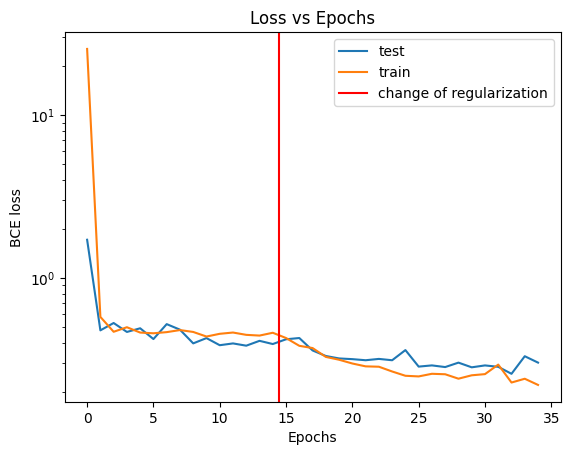

In [40]:
plt.plot(loss_stats_st13c['test'],label='test')
plt.plot(loss_stats_st13c['train'],label='train')
plt.axvline(x=14.5,color='red',label='change of regularization')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.yscale("log")

That works, thus I implement it in a function below. In this function I also run over a loop of difefrent regularization. The larger regularization given is used as starting regularization. 

In [152]:
#prediction, model (class), train data, etst data, train data for prediction, train targets, test targets, epochs , batch size, alpha of fit, 
#regularizations to try, number of feature (not neded for convolutional)
def run_loop_torch2(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    #collects statistics f1 score and  log loss
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        #first with large regularization 
        print(f"initial run of high regularization")
        torch_fit(model3,train,test,20,batch,alpha,loss_stats_test3,l2reg=max(regs))
        print(f"run with given regularization")
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

Below I run that. I partly run it several times with different numbers of iterations to be halfway sure that the minimum is reached. 

It takes time, thus the results are saved. 

In [58]:
regs=[0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3]
stats_4cn=run_loop_torch2(CNNBinary4,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,240,64,0.001,regs)
np.savetxt("conv2d_4n_v2_full_gal_240.txt",stats_4cn)

running reg of 3e-05
initial run of high regularization
Begin training.


/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.23077 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.26086 | Test Loss: 27.61905
Epoch 003: | Train Loss: 10.11268 | Test Loss: 0.52785
Epoch 004: | Train Loss: 0.53887 | Test Loss: 0.60373
Epoch 005: | Train Loss: 0.51998 | Test Loss: 0.50025
Epoch 006: | Train Loss: 0.51324 | Test Loss: 0.47651
Epoch 007: | Train Loss: 0.50408 | Test Loss: 0.49629
Epoch 008: | Train Loss: 0.51884 | Test Loss: 0.47991
Epoch 009: | Train Loss: 0.47978 | Test Loss: 0.49130
Epoch 010: | Train Loss: 0.47841 | Test Loss: 0.58048
Epoch 011: | Train Loss: 0.48058 | Test Loss: 0.48478
Epoch 012: | Train Loss: 0.46706 | Test Loss: 0.47868
Epoch 013: | Train Loss: 0.46301 | Test Loss: 0.46613
Epoch 014: | Train Loss: 0.49075 | Test Loss: 0.52079
Epoch 015: | Train Loss: 0.46417 | Test Loss: 0.46890
Epoch 016: | Train Loss: 0.49001 | Test Loss: 0.46590
Epoch 017: | Train Loss: 0.47945 | Test Loss: 0.43405
Epoch 018: | Train Loss: 0.44392 | Test Loss: 0.45932
Epoch 019: | Train Loss

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48285 | Test Loss: 0.44416
Epoch 002: | Train Loss: 0.37211 | Test Loss: 0.36691
Epoch 003: | Train Loss: 0.33850 | Test Loss: 0.37037
Epoch 004: | Train Loss: 0.32067 | Test Loss: 0.36935
Epoch 005: | Train Loss: 0.31134 | Test Loss: 0.35627
Epoch 006: | Train Loss: 0.32201 | Test Loss: 0.33267
Epoch 007: | Train Loss: 0.30454 | Test Loss: 0.33951
Epoch 008: | Train Loss: 0.28374 | Test Loss: 0.33473
Epoch 009: | Train Loss: 0.28723 | Test Loss: 0.36818
Epoch 010: | Train Loss: 0.27842 | Test Loss: 0.30702
Epoch 011: | Train Loss: 0.26738 | Test Loss: 0.32089
Epoch 012: | Train Loss: 0.27828 | Test Loss: 0.33380
Epoch 013: | Train Loss: 0.26989 | Test Loss: 0.31109
Epoch 014: | Train Loss: 0.26653 | Test Loss: 0.29231
Epoch 015: | Train Loss: 0.25878 | Test Loss: 0.32198
Epoch 016: | Train Loss: 0.25171 | Test Loss: 0.31767
Epoch 017: | Train Loss: 0.22951 | Test Loss: 0.25958
Epoch 018: | Train Loss: 0.21803 | Test Loss: 0.28297
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.06052 | Test Loss: 0.55266
Epoch 154: | Train Loss: 0.07337 | Test Loss: 0.46639
Epoch 155: | Train Loss: 0.06823 | Test Loss: 0.46294
Epoch 156: | Train Loss: 0.06158 | Test Loss: 0.47825
Epoch 157: | Train Loss: 0.05891 | Test Loss: 0.47399
Epoch 158: | Train Loss: 0.09166 | Test Loss: 0.52859
Epoch 159: | Train Loss: 0.06898 | Test Loss: 0.50762
Epoch 160: | Train Loss: 0.06915 | Test Loss: 0.46080
Epoch 161: | Train Loss: 0.06226 | Test Loss: 0.51195
Epoch 162: | Train Loss: 0.05957 | Test Loss: 0.50572
Epoch 163: | Train Loss: 0.05830 | Test Loss: 0.45982
Epoch 164: | Train Loss: 0.06382 | Test Loss: 0.54876
Epoch 165: | Train Loss: 0.07820 | Test Loss: 0.54963
Epoch 166: | Train Loss: 0.05773 | Test Loss: 0.52635
Epoch 167: | Train Loss: 0.06454 | Test Loss: 0.49443
Epoch 168: | Train Loss: 0.05483 | Test Loss: 0.54140
Epoch 169: | Train Loss: 0.04877 | Test Loss: 0.59817
Epoch 170: | Train Loss: 0.05913 | Test Loss: 0.59992
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 23.91195 | Test Loss: 0.77251
Epoch 002: | Train Loss: 0.56933 | Test Loss: 0.51865
Epoch 003: | Train Loss: 0.50357 | Test Loss: 0.48463
Epoch 004: | Train Loss: 0.49805 | Test Loss: 0.47916
Epoch 005: | Train Loss: 0.48823 | Test Loss: 0.47345
Epoch 006: | Train Loss: 0.51314 | Test Loss: 0.46663
Epoch 007: | Train Loss: 0.48762 | Test Loss: 0.50045
Epoch 008: | Train Loss: 0.51011 | Test Loss: 0.44490
Epoch 009: | Train Loss: 0.50252 | Test Loss: 0.43290
Epoch 010: | Train Loss: 0.52906 | Test Loss: 0.47268
Epoch 011: | Train Loss: 0.49535 | Test Loss: 0.44634
Epoch 012: | Train Loss: 0.47883 | Test Loss: 0.50001
Epoch 013: | Train Loss: 0.53189 | Test Loss: 0.67776
Epoch 014: | Train Loss: 0.46601 | Test Loss: 0.46720
Epoch 015: | Train Loss: 0.49420 | Test Loss: 0.47580
Epoch 016: | Train Loss: 0.49603 | Test Loss: 0.54808
Epoch 017: | Train Loss: 0.47412 | Test Loss: 0.40805
Epoch 018: | Train Loss: 0.48926 | Test Loss: 0.90131
Epoch 019: | Train Loss: 0.

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.49448 | Test Loss: 0.39597
Epoch 002: | Train Loss: 0.41990 | Test Loss: 0.36687
Epoch 003: | Train Loss: 0.35902 | Test Loss: 0.35594
Epoch 004: | Train Loss: 0.37297 | Test Loss: 0.37037
Epoch 005: | Train Loss: 0.34665 | Test Loss: 0.36055
Epoch 006: | Train Loss: 0.34744 | Test Loss: 0.33530
Epoch 007: | Train Loss: 0.34932 | Test Loss: 0.45234
Epoch 008: | Train Loss: 0.31475 | Test Loss: 0.35904
Epoch 009: | Train Loss: 0.30715 | Test Loss: 0.38146
Epoch 010: | Train Loss: 0.30405 | Test Loss: 0.33672
Epoch 011: | Train Loss: 0.30903 | Test Loss: 0.34489
Epoch 012: | Train Loss: 0.31918 | Test Loss: 0.33338
Epoch 013: | Train Loss: 0.27639 | Test Loss: 0.28479
Epoch 014: | Train Loss: 0.24772 | Test Loss: 0.23064
Epoch 015: | Train Loss: 0.25314 | Test Loss: 0.24044
Epoch 016: | Train Loss: 0.24396 | Test Loss: 0.21789
Epoch 017: | Train Loss: 0.22588 | Test Loss: 0.20750
Epoch 018: | Train Loss: 0.20319 | Test Loss: 0.21934
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.01506 | Test Loss: 0.34073
Epoch 154: | Train Loss: 0.04895 | Test Loss: 0.52345
Epoch 155: | Train Loss: 0.05269 | Test Loss: 0.29384
Epoch 156: | Train Loss: 0.03073 | Test Loss: 0.56788
Epoch 157: | Train Loss: 0.02544 | Test Loss: 0.33872
Epoch 158: | Train Loss: 0.03684 | Test Loss: 0.32201
Epoch 159: | Train Loss: 0.02476 | Test Loss: 0.54290
Epoch 160: | Train Loss: 0.02519 | Test Loss: 0.34897
Epoch 161: | Train Loss: 0.01949 | Test Loss: 0.33454
Epoch 162: | Train Loss: 0.01556 | Test Loss: 0.31469
Epoch 163: | Train Loss: 0.04231 | Test Loss: 0.45965
Epoch 164: | Train Loss: 0.04253 | Test Loss: 0.47917
Epoch 165: | Train Loss: 0.02596 | Test Loss: 0.31768
Epoch 166: | Train Loss: 0.01793 | Test Loss: 0.32013
Epoch 167: | Train Loss: 0.03374 | Test Loss: 0.40846
Epoch 168: | Train Loss: 0.01876 | Test Loss: 0.46266
Epoch 169: | Train Loss: 0.02464 | Test Loss: 0.37820
Epoch 170: | Train Loss: 0.03316 | Test Loss: 0.36891
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.12576 | Test Loss: 27.61905
Epoch 002: | Train Loss: 6.90554 | Test Loss: 0.55893
Epoch 003: | Train Loss: 0.50555 | Test Loss: 0.50964
Epoch 004: | Train Loss: 0.52986 | Test Loss: 0.69915
Epoch 005: | Train Loss: 0.54807 | Test Loss: 0.56254
Epoch 006: | Train Loss: 0.49906 | Test Loss: 0.47013
Epoch 007: | Train Loss: 0.49844 | Test Loss: 0.52186
Epoch 008: | Train Loss: 0.55548 | Test Loss: 0.49484
Epoch 009: | Train Loss: 0.49000 | Test Loss: 0.45572
Epoch 010: | Train Loss: 0.50753 | Test Loss: 0.71128
Epoch 011: | Train Loss: 0.48592 | Test Loss: 0.43534
Epoch 012: | Train Loss: 0.50324 | Test Loss: 0.44418
Epoch 013: | Train Loss: 0.48480 | Test Loss: 0.42170
Epoch 014: | Train Loss: 0.48815 | Test Loss: 0.44349
Epoch 015: | Train Loss: 0.47275 | Test Loss: 0.42115
Epoch 016: | Train Loss: 0.47222 | Test Loss: 0.43051
Epoch 017: | Train Loss: 0.48644 | Test Loss: 0.42924
Epoch 018: | Train Loss: 0.46068 | Test Loss: 0.42059
Epoch 019: | Train Loss: 0

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.46672 | Test Loss: 0.38467
Epoch 002: | Train Loss: 0.43127 | Test Loss: 0.38492
Epoch 003: | Train Loss: 0.39928 | Test Loss: 0.35829
Epoch 004: | Train Loss: 0.37884 | Test Loss: 0.39703
Epoch 005: | Train Loss: 0.36335 | Test Loss: 0.33864
Epoch 006: | Train Loss: 0.35174 | Test Loss: 0.32787
Epoch 007: | Train Loss: 0.35117 | Test Loss: 0.38087
Epoch 008: | Train Loss: 0.30404 | Test Loss: 0.32008
Epoch 009: | Train Loss: 0.30467 | Test Loss: 0.33830
Epoch 010: | Train Loss: 0.32308 | Test Loss: 0.30729
Epoch 011: | Train Loss: 0.28049 | Test Loss: 0.30025
Epoch 012: | Train Loss: 0.27173 | Test Loss: 0.26198
Epoch 013: | Train Loss: 0.26114 | Test Loss: 0.27122
Epoch 014: | Train Loss: 0.23998 | Test Loss: 0.23358
Epoch 015: | Train Loss: 0.20623 | Test Loss: 0.26460
Epoch 016: | Train Loss: 0.25096 | Test Loss: 0.23119
Epoch 017: | Train Loss: 0.19792 | Test Loss: 0.20863
Epoch 018: | Train Loss: 0.21741 | Test Loss: 0.19684
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.02628 | Test Loss: 0.25158
Epoch 154: | Train Loss: 0.07879 | Test Loss: 0.38323
Epoch 155: | Train Loss: 0.09173 | Test Loss: 0.23885
Epoch 156: | Train Loss: 0.04918 | Test Loss: 0.23717
Epoch 157: | Train Loss: 0.03109 | Test Loss: 0.24024
Epoch 158: | Train Loss: 0.04316 | Test Loss: 0.20800
Epoch 159: | Train Loss: 0.02581 | Test Loss: 0.27884
Epoch 160: | Train Loss: 0.02614 | Test Loss: 0.22842
Epoch 161: | Train Loss: 0.03405 | Test Loss: 0.24438
Epoch 162: | Train Loss: 0.02315 | Test Loss: 0.26136
Epoch 163: | Train Loss: 0.02359 | Test Loss: 0.27067
Epoch 164: | Train Loss: 0.02824 | Test Loss: 0.32294
Epoch 165: | Train Loss: 0.02547 | Test Loss: 0.23054
Epoch 166: | Train Loss: 0.02834 | Test Loss: 0.26255
Epoch 167: | Train Loss: 0.02144 | Test Loss: 0.25501
Epoch 168: | Train Loss: 0.02306 | Test Loss: 0.25428
Epoch 169: | Train Loss: 0.01539 | Test Loss: 0.26246
Epoch 170: | Train Loss: 0.01817 | Test Loss: 0.28153
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.05023 | Test Loss: 27.61905
Epoch 002: | Train Loss: 14.43427 | Test Loss: 0.53948
Epoch 003: | Train Loss: 0.54662 | Test Loss: 0.52566
Epoch 004: | Train Loss: 0.47726 | Test Loss: 0.47601
Epoch 005: | Train Loss: 0.47781 | Test Loss: 0.47692
Epoch 006: | Train Loss: 0.47723 | Test Loss: 0.52340
Epoch 007: | Train Loss: 0.43586 | Test Loss: 0.61149
Epoch 008: | Train Loss: 0.44552 | Test Loss: 0.60275
Epoch 009: | Train Loss: 0.43525 | Test Loss: 0.46807
Epoch 010: | Train Loss: 0.46820 | Test Loss: 0.43697
Epoch 011: | Train Loss: 0.45896 | Test Loss: 0.46525
Epoch 012: | Train Loss: 0.42096 | Test Loss: 0.71531
Epoch 013: | Train Loss: 0.45678 | Test Loss: 0.46298
Epoch 014: | Train Loss: 0.43035 | Test Loss: 0.38999
Epoch 015: | Train Loss: 0.40506 | Test Loss: 0.40039
Epoch 016: | Train Loss: 0.41352 | Test Loss: 0.38769
Epoch 017: | Train Loss: 0.39360 | Test Loss: 0.56662
Epoch 018: | Train Loss: 0.38102 | Test Loss: 0.37266
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48463 | Test Loss: 0.37013
Epoch 002: | Train Loss: 0.39279 | Test Loss: 0.30822
Epoch 003: | Train Loss: 0.37805 | Test Loss: 0.30284
Epoch 004: | Train Loss: 0.41169 | Test Loss: 0.36249
Epoch 005: | Train Loss: 0.39000 | Test Loss: 0.38706
Epoch 006: | Train Loss: 0.33033 | Test Loss: 0.29885
Epoch 007: | Train Loss: 0.30191 | Test Loss: 0.32686
Epoch 008: | Train Loss: 0.28090 | Test Loss: 0.30406
Epoch 009: | Train Loss: 0.30200 | Test Loss: 0.27678
Epoch 010: | Train Loss: 0.25609 | Test Loss: 0.25347
Epoch 011: | Train Loss: 0.27058 | Test Loss: 0.28014
Epoch 012: | Train Loss: 0.25650 | Test Loss: 0.24753
Epoch 013: | Train Loss: 0.25186 | Test Loss: 0.26323
Epoch 014: | Train Loss: 0.23515 | Test Loss: 0.23910
Epoch 015: | Train Loss: 0.22572 | Test Loss: 0.24259
Epoch 016: | Train Loss: 0.21423 | Test Loss: 0.23422
Epoch 017: | Train Loss: 0.19396 | Test Loss: 0.23494
Epoch 018: | Train Loss: 0.23464 | Test Loss: 0.25020
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.08239 | Test Loss: 0.24540
Epoch 154: | Train Loss: 0.07010 | Test Loss: 0.25039
Epoch 155: | Train Loss: 0.07868 | Test Loss: 0.17072
Epoch 156: | Train Loss: 0.08104 | Test Loss: 0.19162
Epoch 157: | Train Loss: 0.08028 | Test Loss: 0.21899
Epoch 158: | Train Loss: 0.09705 | Test Loss: 0.21915
Epoch 159: | Train Loss: 0.11259 | Test Loss: 0.16363
Epoch 160: | Train Loss: 0.05197 | Test Loss: 0.16088
Epoch 161: | Train Loss: 0.04710 | Test Loss: 0.16267
Epoch 162: | Train Loss: 0.04845 | Test Loss: 0.16786
Epoch 163: | Train Loss: 0.05425 | Test Loss: 0.17821
Epoch 164: | Train Loss: 0.03956 | Test Loss: 0.17403
Epoch 165: | Train Loss: 0.04660 | Test Loss: 0.21900
Epoch 166: | Train Loss: 0.06065 | Test Loss: 0.17759
Epoch 167: | Train Loss: 0.03869 | Test Loss: 0.18218
Epoch 168: | Train Loss: 0.07426 | Test Loss: 0.21680
Epoch 169: | Train Loss: 0.04596 | Test Loss: 0.21656
Epoch 170: | Train Loss: 0.05001 | Test Loss: 0.16380
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.12403 | Test Loss: 27.61905
Epoch 002: | Train Loss: 12.34756 | Test Loss: 0.54746
Epoch 003: | Train Loss: 0.54094 | Test Loss: 0.45884
Epoch 004: | Train Loss: 0.52018 | Test Loss: 0.43999
Epoch 005: | Train Loss: 0.48778 | Test Loss: 0.43512
Epoch 006: | Train Loss: 0.49189 | Test Loss: 0.69142
Epoch 007: | Train Loss: 0.49727 | Test Loss: 0.39377
Epoch 008: | Train Loss: 0.47417 | Test Loss: 0.45926
Epoch 009: | Train Loss: 0.48179 | Test Loss: 0.41963
Epoch 010: | Train Loss: 0.46525 | Test Loss: 0.37559
Epoch 011: | Train Loss: 0.47222 | Test Loss: 0.39244
Epoch 012: | Train Loss: 0.45968 | Test Loss: 0.44018
Epoch 013: | Train Loss: 0.45623 | Test Loss: 0.39332
Epoch 014: | Train Loss: 0.47426 | Test Loss: 0.37527
Epoch 015: | Train Loss: 0.44938 | Test Loss: 0.37546
Epoch 016: | Train Loss: 0.45396 | Test Loss: 0.39324
Epoch 017: | Train Loss: 0.44360 | Test Loss: 0.36080
Epoch 018: | Train Loss: 0.44305 | Test Loss: 0.36126
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45104 | Test Loss: 0.36461
Epoch 002: | Train Loss: 0.43124 | Test Loss: 0.43912
Epoch 003: | Train Loss: 0.42473 | Test Loss: 0.35015
Epoch 004: | Train Loss: 0.41322 | Test Loss: 0.33488
Epoch 005: | Train Loss: 0.39213 | Test Loss: 0.37510
Epoch 006: | Train Loss: 0.40172 | Test Loss: 0.36052
Epoch 007: | Train Loss: 0.41688 | Test Loss: 0.32737
Epoch 008: | Train Loss: 0.42573 | Test Loss: 0.31799
Epoch 009: | Train Loss: 0.36634 | Test Loss: 0.34910
Epoch 010: | Train Loss: 0.38234 | Test Loss: 0.30635
Epoch 011: | Train Loss: 0.33983 | Test Loss: 0.35712
Epoch 012: | Train Loss: 0.38080 | Test Loss: 0.31363
Epoch 013: | Train Loss: 0.32814 | Test Loss: 0.31890
Epoch 014: | Train Loss: 0.32752 | Test Loss: 0.30581
Epoch 015: | Train Loss: 0.32996 | Test Loss: 0.51234
Epoch 016: | Train Loss: 0.32710 | Test Loss: 0.29464
Epoch 017: | Train Loss: 0.31435 | Test Loss: 0.32573
Epoch 018: | Train Loss: 0.29532 | Test Loss: 0.31795
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.10562 | Test Loss: 0.12529
Epoch 154: | Train Loss: 0.10273 | Test Loss: 0.14417
Epoch 155: | Train Loss: 0.11026 | Test Loss: 0.13794
Epoch 156: | Train Loss: 0.11469 | Test Loss: 0.13705
Epoch 157: | Train Loss: 0.10621 | Test Loss: 0.14040
Epoch 158: | Train Loss: 0.14130 | Test Loss: 0.17584
Epoch 159: | Train Loss: 0.11716 | Test Loss: 0.18533
Epoch 160: | Train Loss: 0.11403 | Test Loss: 0.15249
Epoch 161: | Train Loss: 0.11210 | Test Loss: 0.14563
Epoch 162: | Train Loss: 0.10988 | Test Loss: 0.14632
Epoch 163: | Train Loss: 0.10630 | Test Loss: 0.16432
Epoch 164: | Train Loss: 0.11296 | Test Loss: 0.14019
Epoch 165: | Train Loss: 0.11120 | Test Loss: 0.15529
Epoch 166: | Train Loss: 0.10464 | Test Loss: 0.14636
Epoch 167: | Train Loss: 0.10245 | Test Loss: 0.15647
Epoch 168: | Train Loss: 0.10597 | Test Loss: 0.15654
Epoch 169: | Train Loss: 0.10207 | Test Loss: 0.19719
Epoch 170: | Train Loss: 0.11672 | Test Loss: 0.15312
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 52.88378 | Test Loss: 27.61905
Epoch 002: | Train Loss: 18.14614 | Test Loss: 0.56962
Epoch 003: | Train Loss: 0.57596 | Test Loss: 0.48558
Epoch 004: | Train Loss: 0.53992 | Test Loss: 0.94030
Epoch 005: | Train Loss: 0.50145 | Test Loss: 0.59624
Epoch 006: | Train Loss: 0.52615 | Test Loss: 0.45135
Epoch 007: | Train Loss: 0.49159 | Test Loss: 0.45145
Epoch 008: | Train Loss: 0.51698 | Test Loss: 0.49349
Epoch 009: | Train Loss: 0.49410 | Test Loss: 0.42087
Epoch 010: | Train Loss: 0.48263 | Test Loss: 0.45817
Epoch 011: | Train Loss: 0.45974 | Test Loss: 0.45591
Epoch 012: | Train Loss: 0.46568 | Test Loss: 0.40788
Epoch 013: | Train Loss: 0.43838 | Test Loss: 0.43611
Epoch 014: | Train Loss: 0.46424 | Test Loss: 0.45011
Epoch 015: | Train Loss: 0.44797 | Test Loss: 0.44445
Epoch 016: | Train Loss: 0.46487 | Test Loss: 0.44557
Epoch 017: | Train Loss: 0.46168 | Test Loss: 0.46306
Epoch 018: | Train Loss: 0.42835 | Test Loss: 0.58347
Epoch 019: | Train Loss: 

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.42802 | Test Loss: 0.37945
Epoch 002: | Train Loss: 0.45014 | Test Loss: 0.38065
Epoch 003: | Train Loss: 0.43079 | Test Loss: 0.37023
Epoch 004: | Train Loss: 0.38804 | Test Loss: 0.35625
Epoch 005: | Train Loss: 0.38615 | Test Loss: 0.34387
Epoch 006: | Train Loss: 0.38546 | Test Loss: 0.33994
Epoch 007: | Train Loss: 0.38745 | Test Loss: 0.36675
Epoch 008: | Train Loss: 0.36194 | Test Loss: 0.33794
Epoch 009: | Train Loss: 0.35487 | Test Loss: 0.31936
Epoch 010: | Train Loss: 0.34797 | Test Loss: 0.33959
Epoch 011: | Train Loss: 0.35109 | Test Loss: 0.31702
Epoch 012: | Train Loss: 0.30425 | Test Loss: 0.40318
Epoch 013: | Train Loss: 0.32666 | Test Loss: 0.30914
Epoch 014: | Train Loss: 0.33173 | Test Loss: 0.29240
Epoch 015: | Train Loss: 0.32921 | Test Loss: 0.28295
Epoch 016: | Train Loss: 0.33430 | Test Loss: 0.29158
Epoch 017: | Train Loss: 0.29523 | Test Loss: 0.29243
Epoch 018: | Train Loss: 0.30031 | Test Loss: 0.29515
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15523 | Test Loss: 0.22848
Epoch 154: | Train Loss: 0.14840 | Test Loss: 0.24177
Epoch 155: | Train Loss: 0.13795 | Test Loss: 0.22800
Epoch 156: | Train Loss: 0.14048 | Test Loss: 0.22160
Epoch 157: | Train Loss: 0.13311 | Test Loss: 0.22598
Epoch 158: | Train Loss: 0.14410 | Test Loss: 0.22688
Epoch 159: | Train Loss: 0.16246 | Test Loss: 0.23311
Epoch 160: | Train Loss: 0.13701 | Test Loss: 0.24438
Epoch 161: | Train Loss: 0.13503 | Test Loss: 0.23272
Epoch 162: | Train Loss: 0.14736 | Test Loss: 0.22878
Epoch 163: | Train Loss: 0.13200 | Test Loss: 0.29288
Epoch 164: | Train Loss: 0.13398 | Test Loss: 0.22761
Epoch 165: | Train Loss: 0.15454 | Test Loss: 0.22758
Epoch 166: | Train Loss: 0.14225 | Test Loss: 0.28060
Epoch 167: | Train Loss: 0.15016 | Test Loss: 0.21677
Epoch 168: | Train Loss: 0.13481 | Test Loss: 0.36425
Epoch 169: | Train Loss: 0.14119 | Test Loss: 0.20872
Epoch 170: | Train Loss: 0.15613 | Test Loss: 0.23427
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.16111 | Test Loss: 27.61905
Epoch 002: | Train Loss: 25.91140 | Test Loss: 27.37370
Epoch 003: | Train Loss: 4.27238 | Test Loss: 0.53893
Epoch 004: | Train Loss: 0.54456 | Test Loss: 0.74218
Epoch 005: | Train Loss: 0.49715 | Test Loss: 0.59413
Epoch 006: | Train Loss: 0.48035 | Test Loss: 0.55873
Epoch 007: | Train Loss: 0.48569 | Test Loss: 0.47163
Epoch 008: | Train Loss: 0.50970 | Test Loss: 0.47321
Epoch 009: | Train Loss: 0.50985 | Test Loss: 0.47123
Epoch 010: | Train Loss: 0.50849 | Test Loss: 0.46974
Epoch 011: | Train Loss: 0.46972 | Test Loss: 0.69036
Epoch 012: | Train Loss: 0.47107 | Test Loss: 0.45714
Epoch 013: | Train Loss: 0.50466 | Test Loss: 0.48399
Epoch 014: | Train Loss: 0.49071 | Test Loss: 0.53203
Epoch 015: | Train Loss: 0.47716 | Test Loss: 0.49394
Epoch 016: | Train Loss: 0.47663 | Test Loss: 0.49887
Epoch 017: | Train Loss: 0.45578 | Test Loss: 0.66542
Epoch 018: | Train Loss: 0.45386 | Test Loss: 0.55368
Epoch 019: | Train Loss:

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43348 | Test Loss: 0.62300
Epoch 002: | Train Loss: 0.40549 | Test Loss: 0.41325
Epoch 003: | Train Loss: 0.44475 | Test Loss: 0.38896
Epoch 004: | Train Loss: 0.41073 | Test Loss: 0.39572
Epoch 005: | Train Loss: 0.37917 | Test Loss: 0.43568
Epoch 006: | Train Loss: 0.39131 | Test Loss: 0.40658
Epoch 007: | Train Loss: 0.37308 | Test Loss: 0.43968
Epoch 008: | Train Loss: 0.36693 | Test Loss: 0.42301
Epoch 009: | Train Loss: 0.37176 | Test Loss: 0.36176
Epoch 010: | Train Loss: 0.36947 | Test Loss: 0.40284
Epoch 011: | Train Loss: 0.37014 | Test Loss: 0.36896
Epoch 012: | Train Loss: 0.39850 | Test Loss: 0.38036
Epoch 013: | Train Loss: 0.35640 | Test Loss: 0.44434
Epoch 014: | Train Loss: 0.34459 | Test Loss: 0.36641
Epoch 015: | Train Loss: 0.35420 | Test Loss: 0.35654
Epoch 016: | Train Loss: 0.35001 | Test Loss: 0.35881
Epoch 017: | Train Loss: 0.34141 | Test Loss: 0.35982
Epoch 018: | Train Loss: 0.34635 | Test Loss: 0.37531
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.22788 | Test Loss: 0.22660
Epoch 154: | Train Loss: 0.22776 | Test Loss: 0.23387
Epoch 155: | Train Loss: 0.23160 | Test Loss: 0.25718
Epoch 156: | Train Loss: 0.23124 | Test Loss: 0.22445
Epoch 157: | Train Loss: 0.25090 | Test Loss: 0.25173
Epoch 158: | Train Loss: 0.24203 | Test Loss: 0.23441
Epoch 159: | Train Loss: 0.23980 | Test Loss: 0.26757
Epoch 160: | Train Loss: 0.22416 | Test Loss: 0.24451
Epoch 161: | Train Loss: 0.23155 | Test Loss: 0.25724
Epoch 162: | Train Loss: 0.22620 | Test Loss: 0.20948
Epoch 163: | Train Loss: 0.22580 | Test Loss: 0.23547
Epoch 164: | Train Loss: 0.23832 | Test Loss: 0.24027
Epoch 165: | Train Loss: 0.22243 | Test Loss: 0.21870
Epoch 166: | Train Loss: 0.22581 | Test Loss: 0.23043
Epoch 167: | Train Loss: 0.24462 | Test Loss: 0.23637
Epoch 168: | Train Loss: 0.23240 | Test Loss: 0.22830
Epoch 169: | Train Loss: 0.23002 | Test Loss: 0.26459
Epoch 170: | Train Loss: 0.23103 | Test Loss: 0.25168
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 18.44536 | Test Loss: 0.60316
Epoch 002: | Train Loss: 0.52855 | Test Loss: 0.50289
Epoch 003: | Train Loss: 0.48506 | Test Loss: 0.47577
Epoch 004: | Train Loss: 0.47376 | Test Loss: 0.48160
Epoch 005: | Train Loss: 0.46569 | Test Loss: 0.58106
Epoch 006: | Train Loss: 0.45690 | Test Loss: 0.45904
Epoch 007: | Train Loss: 0.48816 | Test Loss: 0.44540
Epoch 008: | Train Loss: 0.46643 | Test Loss: 0.46648
Epoch 009: | Train Loss: 0.46065 | Test Loss: 0.47069
Epoch 010: | Train Loss: 0.47728 | Test Loss: 0.41546
Epoch 011: | Train Loss: 0.49425 | Test Loss: 0.38867
Epoch 012: | Train Loss: 0.46785 | Test Loss: 0.39503
Epoch 013: | Train Loss: 0.43727 | Test Loss: 0.38605
Epoch 014: | Train Loss: 0.45121 | Test Loss: 0.37374
Epoch 015: | Train Loss: 0.45081 | Test Loss: 0.35988
Epoch 016: | Train Loss: 0.42043 | Test Loss: 0.34241
Epoch 017: | Train Loss: 0.40669 | Test Loss: 0.34451
Epoch 018: | Train Loss: 0.38979 | Test Loss: 0.39005
Epoch 019: | Train Loss: 0.

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.37734 | Test Loss: 0.41357
Epoch 002: | Train Loss: 0.37353 | Test Loss: 0.44633
Epoch 003: | Train Loss: 0.36514 | Test Loss: 0.30768
Epoch 004: | Train Loss: 0.36610 | Test Loss: 0.28570
Epoch 005: | Train Loss: 0.37104 | Test Loss: 0.29398
Epoch 006: | Train Loss: 0.33525 | Test Loss: 0.29119
Epoch 007: | Train Loss: 0.38241 | Test Loss: 0.28844
Epoch 008: | Train Loss: 0.33792 | Test Loss: 0.34837
Epoch 009: | Train Loss: 0.36696 | Test Loss: 0.33805
Epoch 010: | Train Loss: 0.35414 | Test Loss: 0.29955
Epoch 011: | Train Loss: 0.35894 | Test Loss: 0.30019
Epoch 012: | Train Loss: 0.35959 | Test Loss: 0.34154
Epoch 013: | Train Loss: 0.35048 | Test Loss: 0.31803
Epoch 014: | Train Loss: 0.34049 | Test Loss: 0.32284
Epoch 015: | Train Loss: 0.32831 | Test Loss: 0.60782
Epoch 016: | Train Loss: 0.34559 | Test Loss: 0.28434
Epoch 017: | Train Loss: 0.33292 | Test Loss: 0.29742
Epoch 018: | Train Loss: 0.36071 | Test Loss: 0.31355
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.30126 | Test Loss: 0.33669
Epoch 154: | Train Loss: 0.31017 | Test Loss: 0.29186
Epoch 155: | Train Loss: 0.34823 | Test Loss: 0.27058
Epoch 156: | Train Loss: 0.29358 | Test Loss: 0.26816
Epoch 157: | Train Loss: 0.31620 | Test Loss: 0.29119
Epoch 158: | Train Loss: 0.31249 | Test Loss: 0.37803
Epoch 159: | Train Loss: 0.32317 | Test Loss: 0.26189
Epoch 160: | Train Loss: 0.28412 | Test Loss: 0.29994
Epoch 161: | Train Loss: 0.32264 | Test Loss: 0.27306
Epoch 162: | Train Loss: 0.30417 | Test Loss: 0.26843
Epoch 163: | Train Loss: 0.30134 | Test Loss: 0.32836
Epoch 164: | Train Loss: 0.30635 | Test Loss: 0.30356
Epoch 165: | Train Loss: 0.31256 | Test Loss: 0.31821
Epoch 166: | Train Loss: 0.30926 | Test Loss: 0.27718
Epoch 167: | Train Loss: 0.31978 | Test Loss: 0.27652
Epoch 168: | Train Loss: 0.31075 | Test Loss: 0.28335
Epoch 169: | Train Loss: 0.28300 | Test Loss: 0.27105
Epoch 170: | Train Loss: 0.29253 | Test Loss: 0.29226
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_16878/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.07730 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.19450 | Test Loss: 27.51055
Epoch 003: | Train Loss: 4.84322 | Test Loss: 0.55637
Epoch 004: | Train Loss: 0.53728 | Test Loss: 0.82026
Epoch 005: | Train Loss: 0.52818 | Test Loss: 0.49056
Epoch 006: | Train Loss: 0.52542 | Test Loss: 0.54585
Epoch 007: | Train Loss: 0.52112 | Test Loss: 0.45377
Epoch 008: | Train Loss: 0.51617 | Test Loss: 0.66543
Epoch 009: | Train Loss: 0.49409 | Test Loss: 0.43105
Epoch 010: | Train Loss: 0.51747 | Test Loss: 0.45781
Epoch 011: | Train Loss: 0.49596 | Test Loss: 0.43401
Epoch 012: | Train Loss: 0.48241 | Test Loss: 0.45704
Epoch 013: | Train Loss: 0.49178 | Test Loss: 0.42756
Epoch 014: | Train Loss: 0.48339 | Test Loss: 0.43198
Epoch 015: | Train Loss: 0.47494 | Test Loss: 0.44635
Epoch 016: | Train Loss: 0.46961 | Test Loss: 0.42017
Epoch 017: | Train Loss: 0.51237 | Test Loss: 0.49056
Epoch 018: | Train Loss: 0.48192 | Test Loss: 0.43588
Epoch 019: | Train Loss:

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.47812 | Test Loss: 0.44239
Epoch 002: | Train Loss: 0.46594 | Test Loss: 0.43814
Epoch 003: | Train Loss: 0.46671 | Test Loss: 0.40640
Epoch 004: | Train Loss: 0.45063 | Test Loss: 0.43572
Epoch 005: | Train Loss: 0.46800 | Test Loss: 0.40917
Epoch 006: | Train Loss: 0.44029 | Test Loss: 0.40978
Epoch 007: | Train Loss: 0.45240 | Test Loss: 0.48652
Epoch 008: | Train Loss: 0.43564 | Test Loss: 0.39350
Epoch 009: | Train Loss: 0.45454 | Test Loss: 0.46161
Epoch 010: | Train Loss: 0.47394 | Test Loss: 0.44378
Epoch 011: | Train Loss: 0.45703 | Test Loss: 0.42662
Epoch 012: | Train Loss: 0.45304 | Test Loss: 0.47861
Epoch 013: | Train Loss: 0.44813 | Test Loss: 0.60284
Epoch 014: | Train Loss: 0.43474 | Test Loss: 0.42126
Epoch 015: | Train Loss: 0.45820 | Test Loss: 0.51491
Epoch 016: | Train Loss: 0.45053 | Test Loss: 0.42287
Epoch 017: | Train Loss: 0.44907 | Test Loss: 0.40445
Epoch 018: | Train Loss: 0.43744 | Test Loss: 0.45657
Epoch 019: | Train Loss: 0.4

Epoch 153: | Train Loss: 0.45113 | Test Loss: 0.43025
Epoch 154: | Train Loss: 0.43996 | Test Loss: 0.45383
Epoch 155: | Train Loss: 0.43502 | Test Loss: 0.44767
Epoch 156: | Train Loss: 0.43366 | Test Loss: 0.44405
Epoch 157: | Train Loss: 0.45678 | Test Loss: 0.45389
Epoch 158: | Train Loss: 0.44730 | Test Loss: 0.44817
Epoch 159: | Train Loss: 0.42087 | Test Loss: 0.47276
Epoch 160: | Train Loss: 0.44064 | Test Loss: 0.43535
Epoch 161: | Train Loss: 0.43404 | Test Loss: 0.44722
Epoch 162: | Train Loss: 0.42929 | Test Loss: 0.42482
Epoch 163: | Train Loss: 0.45603 | Test Loss: 0.44564
Epoch 164: | Train Loss: 0.43633 | Test Loss: 0.42373
Epoch 165: | Train Loss: 0.45286 | Test Loss: 0.44777
Epoch 166: | Train Loss: 0.43499 | Test Loss: 0.45031
Epoch 167: | Train Loss: 0.43860 | Test Loss: 0.44572
Epoch 168: | Train Loss: 0.43204 | Test Loss: 0.45541
Epoch 169: | Train Loss: 0.41861 | Test Loss: 0.41716
Epoch 170: | Train Loss: 0.43647 | Test Loss: 0.42011
Epoch 171: | Train Loss: 0.4

I now build a second network a multi layer perceptron to see how important the convolution architecture is in this case. It has 4 layers besides the inout and output. 

In [51]:
#mlp networks with 4 layers 
#two output options 
class BinaryClassification4(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification4, self).__init__()
        self.fc1 = nn.Linear(num_features, 300)
        self.fc2 = nn.Linear(300, 100)  
        self.fc3 = nn.Linear(100, 30)        
        self.fc4 = nn.Linear(30, 10)   
        self.fc5 = nn.Linear(10, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))        
        x = torch.sigmoid(self.fc5(x))
        return (x)

Below I run it, regularized it works also. 

In [29]:
regs=[0.1]
stats_4cn=run_loop_torch2(BinaryClassification4,train_loader,test_loader,train_loader_pred,target_train,target_test,100,64,0.001,regs,num_features=1849)
np.savetxt("mlp_4n_v2_full_gal_100.txt",stats_4cn)

running reg of 0.1
initial run of high regularization
Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59254 | Test Loss: 0.53252
Epoch 002: | Train Loss: 0.58223 | Test Loss: 0.63843
Epoch 003: | Train Loss: 0.54878 | Test Loss: 0.82654
Epoch 004: | Train Loss: 0.54816 | Test Loss: 0.67153
Epoch 005: | Train Loss: 0.56685 | Test Loss: 0.77254
Epoch 006: | Train Loss: 0.53288 | Test Loss: 0.57112
Epoch 007: | Train Loss: 0.53827 | Test Loss: 0.51802
Epoch 008: | Train Loss: 0.49945 | Test Loss: 0.59084
Epoch 009: | Train Loss: 0.54860 | Test Loss: 0.49259
Epoch 010: | Train Loss: 0.50713 | Test Loss: 0.57391
Epoch 011: | Train Loss: 0.51607 | Test Loss: 0.85166
Epoch 012: | Train Loss: 0.52329 | Test Loss: 0.95959
Epoch 013: | Train Loss: 0.54161 | Test Loss: 0.47520
Epoch 014: | Train Loss: 0.52261 | Test Loss: 0.49100
Epoch 015: | Train Loss: 0.51036 | Test Loss: 0.93397
Epoch 016: | Train Loss: 0.51631 | Test Loss: 0.52974
Epoch 017: | Train Loss: 0.51831 | Test Loss: 0.52665
Epoch 018: | Train Loss: 0.48305 | Test Loss: 0.73683
Epoch 019: | Train Loss: 0.5

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50193 | Test Loss: 0.50462
Epoch 002: | Train Loss: 0.50346 | Test Loss: 0.51783
Epoch 003: | Train Loss: 0.48102 | Test Loss: 0.69408
Epoch 004: | Train Loss: 0.46770 | Test Loss: 0.51741
Epoch 005: | Train Loss: 0.49615 | Test Loss: 0.47848
Epoch 006: | Train Loss: 0.59408 | Test Loss: 0.56940
Epoch 007: | Train Loss: 0.53833 | Test Loss: 0.48000
Epoch 008: | Train Loss: 0.56110 | Test Loss: 0.65879
Epoch 009: | Train Loss: 0.50737 | Test Loss: 0.54780
Epoch 010: | Train Loss: 0.51039 | Test Loss: 0.76166
Epoch 011: | Train Loss: 0.47106 | Test Loss: 0.50888
Epoch 012: | Train Loss: 0.50872 | Test Loss: 0.48188
Epoch 013: | Train Loss: 0.51489 | Test Loss: 0.52148
Epoch 014: | Train Loss: 0.48111 | Test Loss: 0.46524
Epoch 015: | Train Loss: 0.49807 | Test Loss: 0.55020
Epoch 016: | Train Loss: 0.51137 | Test Loss: 0.51097
Epoch 017: | Train Loss: 0.48164 | Test Loss: 0.48204
Epoch 018: | Train Loss: 0.48277 | Test Loss: 0.47164
Epoch 019: | Train Loss: 0.4

The function run_loop_torch2 is not very flexible, in particular a single run with different starting regularization is not possible. Thus, I create a slightly changed 

In [158]:
#parameters, model class,train data, test data, train data for prediction, test_tagert, train target, epochs of main fit
#batch isze, alpha iteration, l2/regularziations tried, optinial, initial iterations, optional starting regularziation, num_features if not convolutional
def run_loop_torch2b(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,epoch_init=15,max_reg=0,num_features=0):
    #collects statistics f1 score and  log loss
    stats=np.zeros((8,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partly needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        #first with large regularization 
        print(f"initial run of high regularization")
        if max_reg==0:
            torch_fit(model3,train,test,epoch_init,batch,alpha,loss_stats_test3,l2reg=max(regs))
        else:
            torch_fit(model3,train,test,epoch_init,batch,alpha,loss_stats_test3,l2reg=max_reg)
        print(f"run with given regularization")
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        stats[5,i]=epochs
        if max_reg==0:
            stats[6,i]=max(regs[i])
        else:
            stats[6,i]=max_reg
        #was not there before
        stats[7,i]=epoch_init
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")            
    return stats   

It is run below, several time iterative to get good looking loss curves as function of regularization.

In [160]:
#to be run with 370
regs=[1.e-05,3.e-05,1.e-04,3.e-04,1.e-03,3.e-03,1.e-02,3.e-02,1.e-01,3.e-01]
stats_4cn=run_loop_torch2b(BinaryClassification4,train_loader,test_loader,train_loader_pred,target_train,target_test,10,32,0.001,regs,num_features=1849,max_reg=0.3,epoch_init=15)
np.savetxt("mlp_4n_v2b_full_gal_10.txt",stats_4cn)

10 15
running reg of 1e-05
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.67935 | Test Loss: 0.68823
Epoch 002: | Train Loss: 0.67593 | Test Loss: 0.66084
Epoch 003: | Train Loss: 0.65483 | Test Loss: 0.65162
Epoch 004: | Train Loss: 0.64192 | Test Loss: 0.63955
Epoch 005: | Train Loss: 0.63070 | Test Loss: 0.63136
Epoch 006: | Train Loss: 0.62371 | Test Loss: 0.62635
Epoch 007: | Train Loss: 0.61905 | Test Loss: 0.62327
Epoch 008: | Train Loss: 0.61649 | Test Loss: 0.62120
Epoch 009: | Train Loss: 0.61484 | Test Loss: 0.62037
Epoch 010: | Train Loss: 0.61443 | Test Loss: 0.61967
Epoch 011: | Train Loss: 0.61346 | Test Loss: 0.61927
Epoch 012: | Train Loss: 0.61304 | Test Loss: 0.61911
Epoch 013: | Train Loss: 0.61323 | Test Loss: 0.61939
Epoch 014: | Train Loss: 0.61292 | Test Loss: 0.61905
Epoch 015: | Train Loss: 0.61315 | Test Loss: 0.61953
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59705 | Test Loss: 0.56765
Epoch 002: | Train Loss: 0.58000 | Test Loss: 0.59546
Epoch 003: | Train Loss: 0.58127 | Test Loss: 0.59015
Epoch 004: | Train Loss: 0.57692 | Test Loss: 0.58924
Epoch 005: | Train Loss: 0.57751 | Test Loss: 0.56267
Epoch 006: | Train Loss: 0.54029 | Test Loss: 0.59307
Epoch 007: | Train Loss: 0.53599 | Test Loss: 0.49820
Epoch 008: | Train Loss: 0.49271 | Test Loss: 0.44081
Epoch 009: | Train Loss: 0.52493 | Test Loss: 0.40236
Epoch 010: | Train Loss: 0.42626 | Test Loss: 0.57758
stats of l2reg of  1e-05 are [0.8491  0.83978 0.41973 0.47367]
running reg of 3e-05
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64694 | Test Loss: 0.67289
Epoch 002: | Train Loss: 0.64680 | Test Loss: 0.65289
Epoch 003: | Train Loss: 0.64088 | Test Loss: 0.63757
Epoch 004: | Train Loss: 0.62792 | Test Loss: 0.62971
Epoch 005: | Train Loss: 0.62171 | Test Loss: 0.62499
Epoch 006: | Train Loss: 0.61751 | Test Loss: 0.62230
Epoch 007: | Train Loss: 0.61580 | Test Loss: 0.62027
Epoch 008: | Train Loss: 0.61423 | Test Loss: 0.61976
Epoch 009: | Train Loss: 0.61348 | Test Loss: 0.61944
Epoch 010: | Train Loss: 0.61356 | Test Loss: 0.61871
Epoch 011: | Train Loss: 0.61321 | Test Loss: 0.61882
Epoch 012: | Train Loss: 0.61261 | Test Loss: 0.61872
Epoch 013: | Train Loss: 0.61281 | Test Loss: 0.61903
Epoch 014: | Train Loss: 0.61307 | Test Loss: 0.61921
Epoch 015: | Train Loss: 0.61302 | Test Loss: 0.61936
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59635 | Test Loss: 0.60974
Epoch 002: | Train Loss: 0.57051 | Test Loss: 0.52438
Epoch 003: | Train Loss: 0.51917 | Test Loss: 0.39027
Epoch 004: | Train Loss: 0.37431 | Test Loss: 0.38547
Epoch 005: | Train Loss: 0.37568 | Test Loss: 0.47112
Epoch 006: | Train Loss: 0.38982 | Test Loss: 0.44124
Epoch 007: | Train Loss: 0.38340 | Test Loss: 0.47324
Epoch 008: | Train Loss: 0.38041 | Test Loss: 0.49786
Epoch 009: | Train Loss: 0.36079 | Test Loss: 0.49962
Epoch 010: | Train Loss: 0.33948 | Test Loss: 0.48629
stats of l2reg of  3e-05 are [0.93911 0.92117 0.24196 0.34082]
running reg of 0.0001
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64819 | Test Loss: 0.56469
Epoch 002: | Train Loss: 0.60505 | Test Loss: 0.62623
Epoch 003: | Train Loss: 0.61735 | Test Loss: 0.62107
Epoch 004: | Train Loss: 0.61484 | Test Loss: 0.62007
Epoch 005: | Train Loss: 0.61419 | Test Loss: 0.61941
Epoch 006: | Train Loss: 0.61371 | Test Loss: 0.61898
Epoch 007: | Train Loss: 0.61297 | Test Loss: 0.61944
Epoch 008: | Train Loss: 0.61291 | Test Loss: 0.61964
Epoch 009: | Train Loss: 0.61293 | Test Loss: 0.61948
Epoch 010: | Train Loss: 0.61345 | Test Loss: 0.61955
Epoch 011: | Train Loss: 0.61322 | Test Loss: 0.61959
Epoch 012: | Train Loss: 0.61331 | Test Loss: 0.61924
Epoch 013: | Train Loss: 0.61362 | Test Loss: 0.61929
Epoch 014: | Train Loss: 0.61326 | Test Loss: 0.61923
Epoch 015: | Train Loss: 0.61349 | Test Loss: 0.61896
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.56880 | Test Loss: 0.52428
Epoch 002: | Train Loss: 0.48967 | Test Loss: 0.44622
Epoch 003: | Train Loss: 0.40159 | Test Loss: 0.32635
Epoch 004: | Train Loss: 0.35810 | Test Loss: 0.40064
Epoch 005: | Train Loss: 0.32969 | Test Loss: 0.50518
Epoch 006: | Train Loss: 0.30869 | Test Loss: 0.53969
Epoch 007: | Train Loss: 0.28291 | Test Loss: 0.44308
Epoch 008: | Train Loss: 0.33044 | Test Loss: 0.35887
Epoch 009: | Train Loss: 0.27249 | Test Loss: 0.39153
Epoch 010: | Train Loss: 0.28900 | Test Loss: 0.44394
stats of l2reg of  0.0001 are [0.9485  0.93568 0.24721 0.35558]
running reg of 0.0003
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.61494 | Test Loss: 0.56259
Epoch 002: | Train Loss: 0.57532 | Test Loss: 0.53012
Epoch 003: | Train Loss: 0.55470 | Test Loss: 0.53421
Epoch 004: | Train Loss: 0.53271 | Test Loss: 0.57321
Epoch 005: | Train Loss: 0.55217 | Test Loss: 0.63071
Epoch 006: | Train Loss: 0.57057 | Test Loss: 0.56697
Epoch 007: | Train Loss: 0.52784 | Test Loss: 0.53254
Epoch 008: | Train Loss: 0.54109 | Test Loss: 0.56484
Epoch 009: | Train Loss: 0.54274 | Test Loss: 0.54477
Epoch 010: | Train Loss: 0.53859 | Test Loss: 0.54680
Epoch 011: | Train Loss: 0.55312 | Test Loss: 0.52863
Epoch 012: | Train Loss: 0.50878 | Test Loss: 0.56481
Epoch 013: | Train Loss: 0.54960 | Test Loss: 0.64728
Epoch 014: | Train Loss: 0.51285 | Test Loss: 0.52336
Epoch 015: | Train Loss: 0.53143 | Test Loss: 0.54367
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.52728 | Test Loss: 0.50962
Epoch 002: | Train Loss: 0.46894 | Test Loss: 0.42890
Epoch 003: | Train Loss: 0.36097 | Test Loss: 0.35263
Epoch 004: | Train Loss: 0.30829 | Test Loss: 0.33867
Epoch 005: | Train Loss: 0.27880 | Test Loss: 0.35658
Epoch 006: | Train Loss: 0.29958 | Test Loss: 0.33016
Epoch 007: | Train Loss: 0.27731 | Test Loss: 0.41729
Epoch 008: | Train Loss: 0.28745 | Test Loss: 0.45004
Epoch 009: | Train Loss: 0.26779 | Test Loss: 0.33221
Epoch 010: | Train Loss: 0.26768 | Test Loss: 0.40324
stats of l2reg of  0.0003 are [0.94808 0.93464 0.20505 0.32011]
running reg of 0.001
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.61789 | Test Loss: 0.63705
Epoch 002: | Train Loss: 0.62572 | Test Loss: 0.62557
Epoch 003: | Train Loss: 0.61826 | Test Loss: 0.62181
Epoch 004: | Train Loss: 0.61503 | Test Loss: 0.62061
Epoch 005: | Train Loss: 0.61404 | Test Loss: 0.61943
Epoch 006: | Train Loss: 0.61319 | Test Loss: 0.61962
Epoch 007: | Train Loss: 0.61318 | Test Loss: 0.61937
Epoch 008: | Train Loss: 0.61287 | Test Loss: 0.61941
Epoch 009: | Train Loss: 0.61361 | Test Loss: 0.61934
Epoch 010: | Train Loss: 0.61345 | Test Loss: 0.61897
Epoch 011: | Train Loss: 0.61304 | Test Loss: 0.61906
Epoch 012: | Train Loss: 0.61257 | Test Loss: 0.61909
Epoch 013: | Train Loss: 0.61298 | Test Loss: 0.61936
Epoch 014: | Train Loss: 0.61325 | Test Loss: 0.61924
Epoch 015: | Train Loss: 0.61291 | Test Loss: 0.61912
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59166 | Test Loss: 0.58670
Epoch 002: | Train Loss: 0.53340 | Test Loss: 0.43889
Epoch 003: | Train Loss: 0.39735 | Test Loss: 0.36670
Epoch 004: | Train Loss: 0.34811 | Test Loss: 0.34666
Epoch 005: | Train Loss: 0.30123 | Test Loss: 0.45417
Epoch 006: | Train Loss: 0.33510 | Test Loss: 0.33267
Epoch 007: | Train Loss: 0.33166 | Test Loss: 0.37769
Epoch 008: | Train Loss: 0.26306 | Test Loss: 0.36094
Epoch 009: | Train Loss: 0.30472 | Test Loss: 0.48633
Epoch 010: | Train Loss: 0.25253 | Test Loss: 0.34127
stats of l2reg of  0.001 are [0.95237 0.94048 0.19471 0.27893]
running reg of 0.003
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.61082 | Test Loss: 0.61605
Epoch 002: | Train Loss: 0.58677 | Test Loss: 0.60037
Epoch 003: | Train Loss: 0.57891 | Test Loss: 1.05828
Epoch 004: | Train Loss: 0.58177 | Test Loss: 0.65421
Epoch 005: | Train Loss: 0.55491 | Test Loss: 0.54402
Epoch 006: | Train Loss: 0.55896 | Test Loss: 0.51720
Epoch 007: | Train Loss: 0.50166 | Test Loss: 0.55075
Epoch 008: | Train Loss: 0.52379 | Test Loss: 0.55306
Epoch 009: | Train Loss: 0.55695 | Test Loss: 0.76833
Epoch 010: | Train Loss: 0.53275 | Test Loss: 0.52912
Epoch 011: | Train Loss: 0.52195 | Test Loss: 0.75722
Epoch 012: | Train Loss: 0.55126 | Test Loss: 0.53052
Epoch 013: | Train Loss: 0.56942 | Test Loss: 0.52256
Epoch 014: | Train Loss: 0.54193 | Test Loss: 0.56145
Epoch 015: | Train Loss: 0.51852 | Test Loss: 0.52712
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50662 | Test Loss: 0.47405
Epoch 002: | Train Loss: 0.47352 | Test Loss: 0.44571
Epoch 003: | Train Loss: 0.43725 | Test Loss: 0.38275
Epoch 004: | Train Loss: 0.46474 | Test Loss: 0.37807
Epoch 005: | Train Loss: 0.34509 | Test Loss: 0.39382
Epoch 006: | Train Loss: 0.34383 | Test Loss: 0.41698
Epoch 007: | Train Loss: 0.30646 | Test Loss: 0.33052
Epoch 008: | Train Loss: 0.30452 | Test Loss: 0.40933
Epoch 009: | Train Loss: 0.26602 | Test Loss: 0.37389
Epoch 010: | Train Loss: 0.24223 | Test Loss: 0.33473
stats of l2reg of  0.003 are [0.94377 0.9273  0.23534 0.31395]
running reg of 0.01
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.65265 | Test Loss: 0.57319
Epoch 002: | Train Loss: 0.66642 | Test Loss: 0.65766
Epoch 003: | Train Loss: 0.64530 | Test Loss: 0.64128
Epoch 004: | Train Loss: 0.63214 | Test Loss: 0.63182
Epoch 005: | Train Loss: 0.62389 | Test Loss: 0.62605
Epoch 006: | Train Loss: 0.61886 | Test Loss: 0.62222
Epoch 007: | Train Loss: 0.61504 | Test Loss: 0.62067
Epoch 008: | Train Loss: 0.61477 | Test Loss: 0.61992
Epoch 009: | Train Loss: 0.61358 | Test Loss: 0.61952
Epoch 010: | Train Loss: 0.61343 | Test Loss: 0.61951
Epoch 011: | Train Loss: 0.61369 | Test Loss: 0.61916
Epoch 012: | Train Loss: 0.61310 | Test Loss: 0.61923
Epoch 013: | Train Loss: 0.61311 | Test Loss: 0.61921
Epoch 014: | Train Loss: 0.61283 | Test Loss: 0.61936
Epoch 015: | Train Loss: 0.61309 | Test Loss: 0.61927
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.60186 | Test Loss: 0.59516
Epoch 002: | Train Loss: 0.57883 | Test Loss: 0.56655
Epoch 003: | Train Loss: 0.53924 | Test Loss: 0.60358
Epoch 004: | Train Loss: 0.59090 | Test Loss: 0.59670
Epoch 005: | Train Loss: 0.58435 | Test Loss: 0.59303
Epoch 006: | Train Loss: 0.58094 | Test Loss: 0.59111
Epoch 007: | Train Loss: 0.57855 | Test Loss: 0.59015
Epoch 008: | Train Loss: 0.57730 | Test Loss: 0.58966
Epoch 009: | Train Loss: 0.57670 | Test Loss: 0.58945
Epoch 010: | Train Loss: 0.57660 | Test Loss: 0.58935
stats of l2reg of  0.01 are [0.8491  0.83978 0.57616 0.58935]
running reg of 0.03
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.63829 | Test Loss: 0.61377
Epoch 002: | Train Loss: 0.61403 | Test Loss: 0.57818
Epoch 003: | Train Loss: 0.56949 | Test Loss: 0.53846
Epoch 004: | Train Loss: 0.57264 | Test Loss: 0.54605
Epoch 005: | Train Loss: 0.55933 | Test Loss: 0.59602
Epoch 006: | Train Loss: 0.54675 | Test Loss: 0.60828
Epoch 007: | Train Loss: 0.58272 | Test Loss: 0.61572
Epoch 008: | Train Loss: 0.60700 | Test Loss: 0.61921
Epoch 009: | Train Loss: 0.61332 | Test Loss: 0.61827
Epoch 010: | Train Loss: 0.61278 | Test Loss: 0.61885
Epoch 011: | Train Loss: 0.61266 | Test Loss: 0.61893
Epoch 012: | Train Loss: 0.61313 | Test Loss: 0.61899
Epoch 013: | Train Loss: 0.61262 | Test Loss: 0.61885
Epoch 014: | Train Loss: 0.61285 | Test Loss: 0.61911
Epoch 015: | Train Loss: 0.61289 | Test Loss: 0.61904
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.60127 | Test Loss: 0.59715
Epoch 002: | Train Loss: 0.58103 | Test Loss: 0.59000
Epoch 003: | Train Loss: 0.57721 | Test Loss: 0.58969
Epoch 004: | Train Loss: 0.57771 | Test Loss: 0.58959
Epoch 005: | Train Loss: 0.57782 | Test Loss: 0.58973
Epoch 006: | Train Loss: 0.57729 | Test Loss: 0.58944
Epoch 007: | Train Loss: 0.57707 | Test Loss: 0.58976
Epoch 008: | Train Loss: 0.57749 | Test Loss: 0.58973
Epoch 009: | Train Loss: 0.57746 | Test Loss: 0.58963
Epoch 010: | Train Loss: 0.57695 | Test Loss: 0.58985
stats of l2reg of  0.03 are [0.8491  0.83978 0.5774  0.58985]
running reg of 0.1
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59067 | Test Loss: 0.60132
Epoch 002: | Train Loss: 0.57569 | Test Loss: 0.57924
Epoch 003: | Train Loss: 0.57934 | Test Loss: 0.62959
Epoch 004: | Train Loss: 0.61860 | Test Loss: 0.62167
Epoch 005: | Train Loss: 0.61438 | Test Loss: 0.62039
Epoch 006: | Train Loss: 0.61395 | Test Loss: 0.61971
Epoch 007: | Train Loss: 0.61361 | Test Loss: 0.61937
Epoch 008: | Train Loss: 0.61344 | Test Loss: 0.61884
Epoch 009: | Train Loss: 0.61269 | Test Loss: 0.61920
Epoch 010: | Train Loss: 0.61333 | Test Loss: 0.61899
Epoch 011: | Train Loss: 0.61330 | Test Loss: 0.61897
Epoch 012: | Train Loss: 0.61270 | Test Loss: 0.61933
Epoch 013: | Train Loss: 0.61312 | Test Loss: 0.61926
Epoch 014: | Train Loss: 0.61312 | Test Loss: 0.61922
Epoch 015: | Train Loss: 0.61350 | Test Loss: 0.61920
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.60620 | Test Loss: 0.60816
Epoch 002: | Train Loss: 0.59731 | Test Loss: 0.60266
Epoch 003: | Train Loss: 0.59240 | Test Loss: 0.60008
Epoch 004: | Train Loss: 0.59013 | Test Loss: 0.59845
Epoch 005: | Train Loss: 0.58829 | Test Loss: 0.59757
Epoch 006: | Train Loss: 0.58785 | Test Loss: 0.59709
Epoch 007: | Train Loss: 0.58711 | Test Loss: 0.59687
Epoch 008: | Train Loss: 0.58690 | Test Loss: 0.59683
Epoch 009: | Train Loss: 0.58703 | Test Loss: 0.59668
Epoch 010: | Train Loss: 0.58707 | Test Loss: 0.59670
stats of l2reg of  0.1 are [0.8491  0.83978 0.58697 0.5967 ]
running reg of 0.3
initial run of high regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.69083 | Test Loss: 0.66347
Epoch 002: | Train Loss: 0.65160 | Test Loss: 0.64568
Epoch 003: | Train Loss: 0.63603 | Test Loss: 0.63468
Epoch 004: | Train Loss: 0.62605 | Test Loss: 0.62777
Epoch 005: | Train Loss: 0.62041 | Test Loss: 0.62377
Epoch 006: | Train Loss: 0.61694 | Test Loss: 0.62166
Epoch 007: | Train Loss: 0.61500 | Test Loss: 0.62028
Epoch 008: | Train Loss: 0.61395 | Test Loss: 0.61968
Epoch 009: | Train Loss: 0.61336 | Test Loss: 0.61938
Epoch 010: | Train Loss: 0.61338 | Test Loss: 0.61935
Epoch 011: | Train Loss: 0.61334 | Test Loss: 0.61955
Epoch 012: | Train Loss: 0.61336 | Test Loss: 0.61914
Epoch 013: | Train Loss: 0.61305 | Test Loss: 0.61884
Epoch 014: | Train Loss: 0.61250 | Test Loss: 0.61892
Epoch 015: | Train Loss: 0.61285 | Test Loss: 0.61942
run with given regularization
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.61313 | Test Loss: 0.61958
Epoch 002: | Train Loss: 0.61317 | Test Loss: 0.61939
Epoch 003: | Train Loss: 0.61272 | Test Loss: 0.61942
Epoch 004: | Train Loss: 0.61311 | Test Loss: 0.61976
Epoch 005: | Train Loss: 0.61395 | Test Loss: 0.61903
Epoch 006: | Train Loss: 0.61305 | Test Loss: 0.61913
Epoch 007: | Train Loss: 0.61277 | Test Loss: 0.61941
Epoch 008: | Train Loss: 0.61350 | Test Loss: 0.61908
Epoch 009: | Train Loss: 0.61315 | Test Loss: 0.61921
Epoch 010: | Train Loss: 0.61328 | Test Loss: 0.61905
stats of l2reg of  0.3 are [0.8491  0.83978 0.61295 0.61905]
full stats are [[1.0000e-05 8.4910e-01 8.3978e-01 4.1973e-01 4.7367e-01 1.0000e+01
  3.0000e-01 1.5000e+01]
 [3.0000e-05 9.3911e-01 9.2117e-01 2.4196e-01 3.4082e-01 1.0000e+01
  3.0000e-01 1.5000e+01]
 [1.0000e-04 9.4850e-01 9.3568e-01 2.4721e-01 3.5558e-01 1.0000e+01
  3.0000e-01 1.5000e+01]
 [3.0000e-04 9.4808e-01 9.3464e-01 2.0505e-01 3.2011e-01 1.0000e+01
  3.0000e-01 1.5000e+01]
 [1.0000e-03

Below I combine the different runs, in combination the one with larger number of epoch has preferences as long as it did not jump out of the minimum. 

In [135]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")
#main run
stats_conv=np.loadtxt("conv2d_4n_v2_full_gal_240.txt")
#running more iterations for smallest regularziation which need more
stats_conv2=np.loadtxt("conv2d_4n_v2b_full_gal_360.txt")
stats_conv3=np.loadtxt("conv2d_4n_v2b_full_gal_340.txt")
stats_conv4=np.loadtxt("conv2d_4n_v2b_full_gal_350.txt")
#compare smaller and large iterations runs
print(stats_conv[0:5,0],stats_conv2[0:5])
print(stats_conv[0:5,1],stats_conv3[0:5])
print(stats_conv[0:5,2],stats_conv4[0:5])
stats_conv[0:5,0]=stats_conv2[0:5]
stats_conv[0:5,1]=stats_conv3[0:5]
stats_conv[0:5,2]=stats_conv4[0:5]
stats_mlp1=np.loadtxt("mlp_4n_v2_full_gal_240.txt")
stats_mlp2=np.loadtxt("mlp_4n_v2_full_gal_400.txt")
stats_mlp3=np.loadtxt("mlp_4n_v2_full_gal_100.txt")
stats_mlp4=np.loadtxt("mlp_4n_v2b_full_gal_300.txt")
stats_mlp5=np.loadtxt("mlp_4n_v2b_full_gal_360.txt")
stats_mlp6=np.loadtxt("mlp_4n_v2b_full_gal_440.txt")
print(stats_mlp5,stats_mlp6)
stats_mlpb=stats_mlp2.copy()
for i in range(3):
    if stats_mlp4[2,i]>stats_mlpb[2,i]:
        stats_mlpb[0:5,i]=stats_mlp4[0:5,i]

stats_mlpb[0:5,7]=stats_mlp3[0:5]
stats_mlp=np.zeros((5,10))
stats_mlp[:,1:10]=stats_mlpb
stats_mlp[0:5,0]=stats_mlp6[0:5]
print(stats_mlp[0])

[3.00000000e-05 9.94837970e-01 9.50568679e-01 2.57793727e-02
 4.77459226e-01] [3.00000000e-05 9.99569892e-01 9.65562053e-01 4.09768116e-03
 4.02625833e-01]
[1.00000000e-04 9.98279817e-01 9.66135023e-01 1.51332844e-02
 2.85614884e-01] [1.00000000e-04 1.00000000e+00 9.71652857e-01 3.23542002e-04
 3.67941400e-01]
[3.00000000e-04 9.99426277e-01 9.65577724e-01 4.74987576e-03
 3.00863211e-01] [3.00000000e-04 9.99713221e-01 9.66884532e-01 1.73040073e-02
 2.10616766e-01]
[1.00000000e-05 9.84787600e-01 9.49441891e-01 9.93038767e-02
 4.80299334e-01 3.60000000e+02 3.00000000e-01 1.50000000e+01] [1.00000000e-05 9.85895222e-01 9.43537715e-01 8.71837191e-02
 3.67010175e-01 4.40000000e+02 3.00000000e-01 1.50000000e+01]
[1.e-05 3.e-05 1.e-04 3.e-04 1.e-03 3.e-03 1.e-02 3.e-02 1.e-01 3.e-01]


First I plot the F1 score.

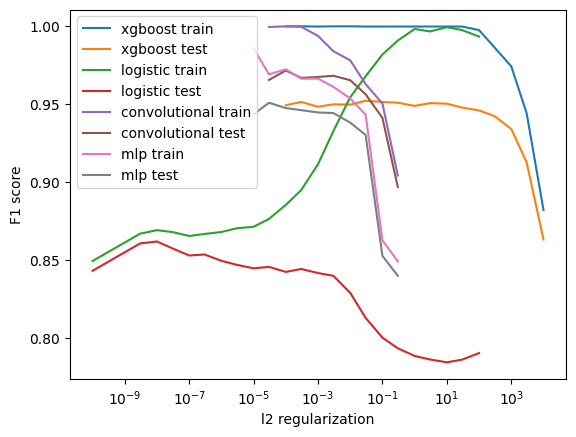

In [43]:
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[1],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[2],label='mlp test')
plt.legend(loc="best")

plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

Logistic is clearly worse than the rest, I now zoom into the range at the differences between the others are better visibile.

(0.92, 1.001)

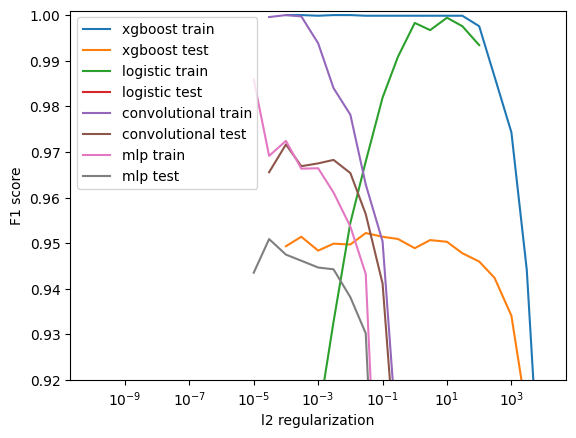

In [44]:

plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
#plt.plot(stats_mlp[0],stats_mlp1[1],label='mlp train')
#plt.plot(stats_mlp[0],stats_mlp1[2],label='mlp test')
plt.plot(stats_mlp[0],stats_mlp[1],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[2],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.92,1.001)

Multi layer percetron has the smallest F1 in train, thus it is likely not fully converged or smaller regularization are needed to explore. However, that is not real problem, since performance in test is what matters. 

Convolutional network has the highest F1 score for test, xgboost and multi layer percetron have similar goodness in the F1 score. All peaks are rather borad and in case of the neural network likely influenced by the number of iterations and randomness. 

I am now looking on log loss. I zoom to ignore the very bad part of logistic. 

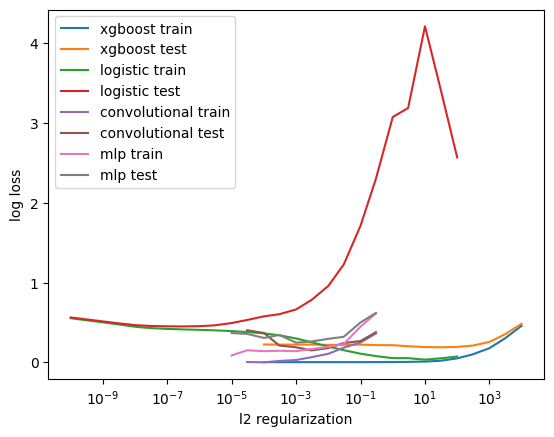

In [45]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")

Again logistic is clealy worst, the small value at the highest numeric l2 regularization (is smallest in reality since invrese defined) is very likely caused by bad convergence, but since it is clearly not the best solution, I can ignore it. 

Below I zoom again in the better values, ignoring the worst logistic ones. 

(0.0, 0.6)

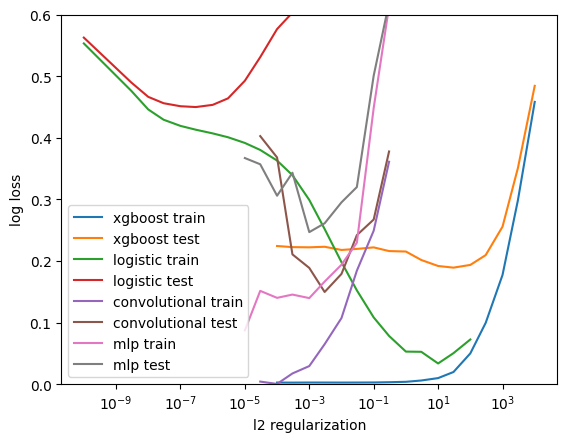

In [65]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
#plt.plot(stats_mlp2[0],stats_mlp2[3],label='mlp train 2')
#plt.plot(stats_mlp2[0],stats_mlp2[4],label='mlp test 2')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,0.6)

Here the minima are clearer. Thus I use it to choose them. The F1 score is still close to the best since the minium is broad here.
The best model is convolutional network, then xgbboost and then percetron network and logistic is clearly worse.

I now run the best models  and compare the miss classification of the different ones. 

First logistic and xgboost which run rather fast. 

In [46]:
best_reg=np.min(stats_log[0,np.argmin(stats_log[4])])
print(f"best regularization of logistic is {best_reg}")
log_reg=LogisticRegression(max_iter=10000,penalty='l2',C=best_reg).fit(feature_train,target_train)
#very fast 

best regularization of logistic is 3e-07


In [47]:
best_reg=np.min(stats_xgb[0,np.argmin(stats_xgb[4])])
print(f"best regularization of xgboost is {best_reg}")
xgb_reg=XGBClassifier(max_depth=6,reg_lambda=best_reg).fit(feature_train,target_train).fit(feature_train,target_train)
#not as fast is thus saved 
xgb_reg.save_model("xgboost_model_spiral_ell_v1.json")

best regularization of xgboost is 30.0


In [ ]:
xgb_reg=XGBClassifier()
xgb_reg.load_model("xgboost_model_spiral_ell_v1.json")

Now I run and save the best convolutional network. 

In [78]:
model3 =CNNBinary4()            
model3.to(device)
loss_stats_test3 = {
'train': [], 'test': []
}
#first with large regularization 
best_reg=np.min(stats_conv[0,np.argmin(stats_conv[4])])
print(f"stats were {stats_conv[:,np.argmin(stats_conv[4])]}")
start_epochs=15
start_reg=0.3
print(f"run with initial regularization")
torch_fit(model3,train_im_loader,test_im_loader,start_epochs,32,0.001,loss_stats_test3,l2reg=start_reg)
print(f"run with given regularization")
end_epochs=300
torch_fit(model3,train_im_loader,test_im_loader,end_epochs,32,0.001,loss_stats_test3,l2reg=best_reg)
test_pred=pred_torch(model3,test_im_loader)
train_pred=pred_torch(model3,train_im_loader_pred)
stats=np.zeros((8))
stats[0]=best_reg
stats[1]=f1_score(target_train,np.round(train_pred))
stats[2]=f1_score(target_test,np.round(test_pred))
stats[3]=log_loss(target_train,(train_pred))
stats[4]=log_loss(target_test,(test_pred))   
stats[5]=end_epochs
stats[6]=start_reg
stats[7]=start_epochs
print(f"stats are {np.round(stats,5)}")

PATH='/home/tobias/ml-testing/astr-images/conv2d_2layers_reg0.003_300epochs.pkl'
torch.save(model3.state_dict(), PATH)

stats were [0.003      0.98400457 0.96826087 0.06484757 0.14956885]
run with initial regularization
Begin training.


/tmp/ipykernel_2552/3106201501.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) #old


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 26.19947 | Test Loss: 27.61905
Epoch 002: | Train Loss: 26.23874 | Test Loss: 27.61905
Epoch 003: | Train Loss: 11.57320 | Test Loss: 0.54572
Epoch 004: | Train Loss: 0.55398 | Test Loss: 0.51217
Epoch 005: | Train Loss: 0.49993 | Test Loss: 0.95135
Epoch 006: | Train Loss: 0.54295 | Test Loss: 0.49248
Epoch 007: | Train Loss: 0.52341 | Test Loss: 0.43762
Epoch 008: | Train Loss: 0.47612 | Test Loss: 0.72416
Epoch 009: | Train Loss: 0.47360 | Test Loss: 0.42792
Epoch 010: | Train Loss: 0.47113 | Test Loss: 0.40222
Epoch 011: | Train Loss: 0.45061 | Test Loss: 0.59306
Epoch 012: | Train Loss: 0.47290 | Test Loss: 0.49933
Epoch 013: | Train Loss: 0.44329 | Test Loss: 0.53868
Epoch 014: | Train Loss: 0.45929 | Test Loss: 0.41506
Epoch 015: | Train Loss: 0.44920 | Test Loss: 0.39446
run with given regularization
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.41773 | Test Loss: 0.41661
Epoch 002: | Train Loss: 0.41995 | Test Loss: 0.36230
Epoch 003: | Train Loss: 0.41314 | Test Loss: 0.34218
Epoch 004: | Train Loss: 0.33343 | Test Loss: 0.35647
Epoch 005: | Train Loss: 0.34065 | Test Loss: 0.28299
Epoch 006: | Train Loss: 0.33161 | Test Loss: 0.31533
Epoch 007: | Train Loss: 0.30173 | Test Loss: 0.36049
Epoch 008: | Train Loss: 0.26758 | Test Loss: 0.26357
Epoch 009: | Train Loss: 0.27207 | Test Loss: 0.25954
Epoch 010: | Train Loss: 0.28350 | Test Loss: 0.25702
Epoch 011: | Train Loss: 0.25693 | Test Loss: 0.24760
Epoch 012: | Train Loss: 0.24542 | Test Loss: 0.26416
Epoch 013: | Train Loss: 0.26459 | Test Loss: 0.24563
Epoch 014: | Train Loss: 0.27324 | Test Loss: 0.24688
Epoch 015: | Train Loss: 0.23775 | Test Loss: 0.24132
Epoch 016: | Train Loss: 0.23375 | Test Loss: 0.23073
Epoch 017: | Train Loss: 0.21890 | Test Loss: 0.22897
Epoch 018: | Train Loss: 0.23533 | Test Loss: 0.21771
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.09697 | Test Loss: 0.15347
Epoch 154: | Train Loss: 0.09259 | Test Loss: 0.20664
Epoch 155: | Train Loss: 0.10601 | Test Loss: 0.15342
Epoch 156: | Train Loss: 0.08724 | Test Loss: 0.18147
Epoch 157: | Train Loss: 0.08558 | Test Loss: 0.16018
Epoch 158: | Train Loss: 0.11336 | Test Loss: 0.23309
Epoch 159: | Train Loss: 0.10535 | Test Loss: 0.16352
Epoch 160: | Train Loss: 0.11927 | Test Loss: 0.21301
Epoch 161: | Train Loss: 0.08861 | Test Loss: 0.15081
Epoch 162: | Train Loss: 0.09462 | Test Loss: 0.15588
Epoch 163: | Train Loss: 0.11872 | Test Loss: 0.14608
Epoch 164: | Train Loss: 0.08686 | Test Loss: 0.15274
Epoch 165: | Train Loss: 0.09228 | Test Loss: 0.16496
Epoch 166: | Train Loss: 0.09908 | Test Loss: 0.14504
Epoch 167: | Train Loss: 0.09158 | Test Loss: 0.14957
Epoch 168: | Train Loss: 0.09580 | Test Loss: 0.14732
Epoch 169: | Train Loss: 0.09008 | Test Loss: 0.15210
Epoch 170: | Train Loss: 0.09050 | Test Loss: 0.15627
Epoch 171: | Train Loss: 0.0

Now determine the best regularization of the preceptron and run it then. 

In [48]:
best_reg=np.min(stats_mlp[0,np.argmin(stats_mlp[4])])
print(best_reg)

0.001


In [83]:
model3 =BinaryClassification4(1849)            
model3.to(device)
loss_stats_test3 = {
'train': [], 'test': []
}
#first with large regularization 
best_reg=np.min(stats_mlp[0,np.argmin(stats_mlp[4])])
print(f"stats were {stats_mlp[:,np.argmin(stats_mlp[4])]}")
start_epochs=15
start_reg=0.3
print(f"run with initial regularization")
torch_fit(model3,train_loader,test_loader,start_epochs,32,0.001,loss_stats_test3,l2reg=start_reg)
print(f"run with given regularization")
end_epochs=300
torch_fit(model3,train_loader,test_loader,end_epochs,32,0.001,loss_stats_test3,l2reg=best_reg)
test_pred=pred_torch(model3,test_loader)
train_pred=pred_torch(model3,train_loader_pred)
stats=np.zeros((8))
stats[0]=best_reg
stats[1]=f1_score(target_train,np.round(train_pred))
stats[2]=f1_score(target_test,np.round(test_pred))
stats[3]=log_loss(target_train,(train_pred))
stats[4]=log_loss(target_test,(test_pred))   
stats[5]=end_epochs
stats[6]=start_reg
stats[7]=start_epochs
print(f"stats are {np.round(stats,5)}")

PATH='/home/tobias/ml-testing/astr-images/mlp_4layers_reg0.001_300epochs.pkl'
torch.save(model3.state_dict(), PATH)

stats were [0.001      0.96643519 0.94467896 0.13965413 0.24675065]
run with initial regularization
Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.66520 | Test Loss: 0.63799
Epoch 002: | Train Loss: 0.59232 | Test Loss: 0.58202
Epoch 003: | Train Loss: 0.57778 | Test Loss: 0.57821
Epoch 004: | Train Loss: 0.56311 | Test Loss: 0.57661
Epoch 005: | Train Loss: 0.56891 | Test Loss: 0.63431
Epoch 006: | Train Loss: 0.62364 | Test Loss: 0.62502
Epoch 007: | Train Loss: 0.61773 | Test Loss: 0.62184
Epoch 008: | Train Loss: 0.61482 | Test Loss: 0.62023
Epoch 009: | Train Loss: 0.61373 | Test Loss: 0.61952
Epoch 010: | Train Loss: 0.61343 | Test Loss: 0.61930
Epoch 011: | Train Loss: 0.61298 | Test Loss: 0.61958
Epoch 012: | Train Loss: 0.61344 | Test Loss: 0.61903
Epoch 013: | Train Loss: 0.61221 | Test Loss: 0.61973
Epoch 014: | Train Loss: 0.61368 | Test Loss: 0.61958
Epoch 015: | Train Loss: 0.61303 | Test Loss: 0.61922
run with given regularization
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59241 | Test Loss: 0.51718
Epoch 002: | Train Loss: 0.50325 | Test Loss: 0.40298
Epoch 003: | Train Loss: 0.40907 | Test Loss: 0.59328
Epoch 004: | Train Loss: 0.34059 | Test Loss: 0.33638
Epoch 005: | Train Loss: 0.32011 | Test Loss: 0.46016
Epoch 006: | Train Loss: 0.33630 | Test Loss: 0.40755
Epoch 007: | Train Loss: 0.25466 | Test Loss: 0.44525
Epoch 008: | Train Loss: 0.26291 | Test Loss: 0.40470
Epoch 009: | Train Loss: 0.21956 | Test Loss: 0.35442
Epoch 010: | Train Loss: 0.26532 | Test Loss: 0.38426
Epoch 011: | Train Loss: 0.25528 | Test Loss: 0.56102
Epoch 012: | Train Loss: 0.25404 | Test Loss: 0.32934
Epoch 013: | Train Loss: 0.23646 | Test Loss: 0.34353
Epoch 014: | Train Loss: 0.23493 | Test Loss: 0.43417
Epoch 015: | Train Loss: 0.26048 | Test Loss: 0.56647
Epoch 016: | Train Loss: 0.26258 | Test Loss: 0.34829
Epoch 017: | Train Loss: 0.22564 | Test Loss: 0.33873
Epoch 018: | Train Loss: 0.21214 | Test Loss: 0.55401
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.19243 | Test Loss: 0.57825
Epoch 154: | Train Loss: 0.25949 | Test Loss: 0.48587
Epoch 155: | Train Loss: 0.16714 | Test Loss: 0.39016
Epoch 156: | Train Loss: 0.16718 | Test Loss: 0.42259
Epoch 157: | Train Loss: 0.26061 | Test Loss: 0.38448
Epoch 158: | Train Loss: 0.15900 | Test Loss: 0.38588
Epoch 159: | Train Loss: 0.15158 | Test Loss: 0.32799
Epoch 160: | Train Loss: 0.16993 | Test Loss: 0.35978
Epoch 161: | Train Loss: 0.17297 | Test Loss: 0.30669
Epoch 162: | Train Loss: 0.16789 | Test Loss: 0.38398
Epoch 163: | Train Loss: 0.17947 | Test Loss: 0.37649
Epoch 164: | Train Loss: 0.16978 | Test Loss: 0.49004
Epoch 165: | Train Loss: 0.16794 | Test Loss: 0.39190
Epoch 166: | Train Loss: 0.19367 | Test Loss: 0.42411
Epoch 167: | Train Loss: 0.15425 | Test Loss: 0.42933
Epoch 168: | Train Loss: 0.20126 | Test Loss: 0.39164
Epoch 169: | Train Loss: 0.15399 | Test Loss: 0.37022
Epoch 170: | Train Loss: 0.17362 | Test Loss: 0.41959
Epoch 171: | Train Loss: 0.1

These best neural networks are then loaded. 

In [49]:
PATH='/home/tobias/ml-testing/astr-images/conv2d_2layers_reg0.003_300epochs.pkl'
model_conv2 =CNNBinary4()
model_conv2.load_state_dict(torch.load(PATH))
model_conv2.eval()

/tmp/ipykernel_8518/494503414.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight) # initialize parameters


CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [52]:
PATH2='/home/tobias/ml-testing/astr-images/mlp_4layers_reg0.001_300epochs.pkl'
model_mlp =BinaryClassification4(1849)
model_mlp.load_state_dict(torch.load(PATH2))
model_mlp.eval()

BinaryClassification4(
  (fc1): Linear(in_features=1849, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

I then get the prediction for all models.

In [55]:
m_test_pred=pred_torch(model_mlp,test_loader)
m_train_pred=pred_torch(model_mlp,train_loader_pred)
c_test_pred=pred_torch(model_conv2,test_im_loader)
c_train_pred=pred_torch(model_conv2,train_im_loader_pred)
x_train_pred=xgb_reg.predict_proba(feature_train)
x_test_pred=xgb_reg.predict_proba(feature_test)
l_train_pred=log_reg.predict_proba(feature_train)
l_test_pred=log_reg.predict_proba(feature_test)

First I get the confusion matrix of all best models for test and train.

In [64]:
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred[:,1]))
l_conf_test = confusion_matrix(target_test, np.round(l_test_pred[:,1]))
print("logistic")
print("confusion matrix train")
print(l_conf_train)
print("confusion matrix test")
print(l_conf_test)
x_conf_train = confusion_matrix(target_train, np.round(x_train_pred[:,1]))
x_conf_test = confusion_matrix(target_test, np.round(x_test_pred[:,1]))
print("xgboost")
print("confusion matrix train")
print(x_conf_train)
print("confusion matrix test")
print(x_conf_test)
m_conf_train = confusion_matrix(target_train, np.round(m_train_pred[:]))
m_conf_test = confusion_matrix(target_test, np.round(m_test_pred[:]))
print("multilayer perceptron")
print("confusion matrix train")
print(m_conf_train)
print("confusion matrix test")
print(m_conf_test)
c_conf_train = confusion_matrix(target_train, np.round(c_train_pred[:]))
c_conf_test = confusion_matrix(target_test, np.round(c_test_pred[:]))
print("convolutional")
print("confusion matrix train")
print(c_conf_train)
print("confusion matrix test")
print(c_conf_test)

logistic
confusion matrix train
[[ 479  760]
 [ 239 3247]]
confusion matrix test
[[ 321  549]
 [ 174 2106]]
xgboost
confusion matrix train
[[1238    1]
 [   0 3486]]
confusion matrix test
[[ 741  129]
 [ 110 2170]]
multilayer perceptron
confusion matrix train
[[1182   57]
 [ 223 3263]]
confusion matrix test
[[ 806   64]
 [ 211 2069]]
convolutional
confusion matrix train
[[1194   45]
 [  55 3431]]
confusion matrix test
[[ 791   79]
 [  63 2217]]


Logistic is here clearly worse. Then it depends on the measure. The precptron is best of having a pure sample of spirals but the elliptical in it are more polluted. Convolutional is better for the rarer spirals, xgboost is in between. 

Displaying galaxies in test which wrong classified by logistic and not by convolutional.

Test function for one.

In [68]:
def plot_image(image,target,x):
    plt.axis('off')
    plt.title(f"spiral is {bool(target[x])}")
    plt.imshow(abs(image[x,0,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

Test function for several galaxies. 

In [174]:
#image_set, true class, better prediction, list of images wanted, single or several prediction, other prediction (can be omitted),  display scale default 0.5
def plot_images(image,target,prediction1, x,single=False,prediction2=0,scale=0.5):
    print(x_test_pred.shape,len(c_test_pred))
    list_bad=[]
    for i in range(len(prediction1)):
        if single==False:
            if round(prediction1[i])==target[i] and round(prediction1[i])==round(prediction2[i]):
                list_bad.append(i)
        else:
            if round(prediction1[i])!=target[i]:
                list_bad.append(i)                
    #print(list_bad)        
    plt.axis('off')
    dimage=np.zeros((43,len(x)*43+len(x)-1))
    string=''
    for i in range(len(x)):
        dimage[:,0+i*44:43+i*44]=(abs(image[list_bad[x[i]],0,:,:])**scale)/(np.max(abs(image[list_bad[x[i]],0,:,:])**scale))
        if bool(target[list_bad[x[i]]])==False and i!=len(x)-1:
            string+='elliptical          '
        elif bool(target[list_bad[x[i]]])==False and i==len(x)-1:
            string+='elliptical'            
        elif  bool(target[list_bad[x[i]]])==True and i!=len(x)-1:
            string+='spiral              '
        else:
            string+='spiral'            
    plt.title(string)     
    plt.imshow(dimage,cmap=cm.gray, interpolation='nearest')

Below I show some at a time. 

(3150, 2) 3150


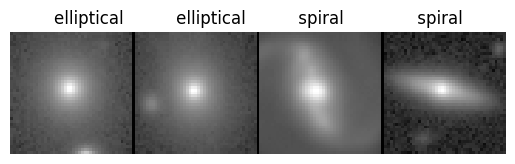

In [161]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=l_test_pred[:,0],scale=0.25)

(3150, 2) 3150


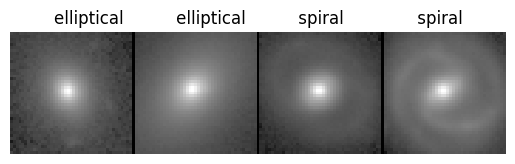

In [131]:
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],prediction2=l_test_pred[:,0],scale=0.25)

(3150, 2) 3150


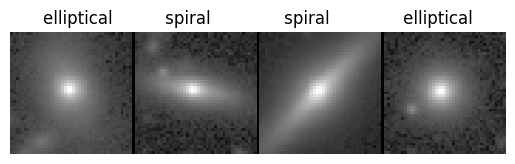

In [132]:
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],prediction2=l_test_pred[:,0],scale=0.25)

(3150, 2) 3150


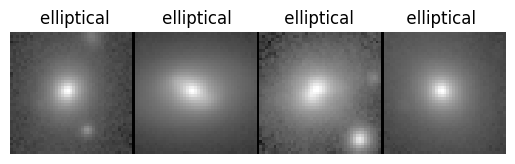

In [133]:
plot_images(image_test,target_test,c_test_pred,[12,13,14,15],prediction2=l_test_pred[:,0],scale=0.25)

For all example I looked on until now the type is obvious to the expect eye. Many are elliptical for them teh main reason is likely that as the minor close there are more often  missclassified. In case of missclassified spirals it is visible, that many are edge on spirals. That is not surprising, when they are minority of all spirals, since they are clearly different from face on spirals and logistic cannot combine different subclasses when they are too different. 

That should be different for xgbboost on which I look now. 

(3150, 2) 3150


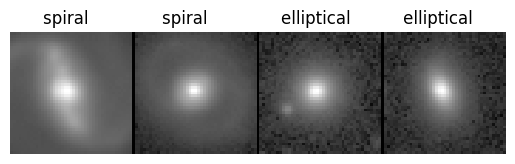

In [162]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=x_test_pred[:,0],scale=0.25)

(3150, 2) 3150


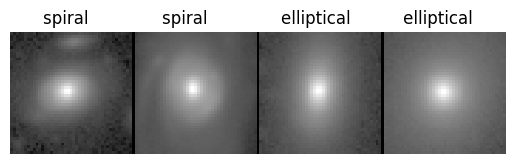

In [164]:
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],prediction2=x_test_pred[:,0],scale=0.25)
#first is maybe not a spiral

(3150, 2) 3150


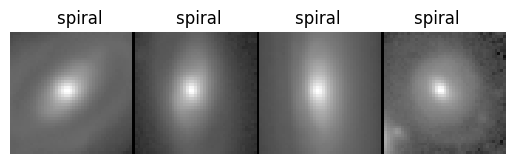

In [165]:
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],prediction2=x_test_pred[:,0],scale=0.25)
#second and third maybe not a spiral per eye

(3150, 2) 3150


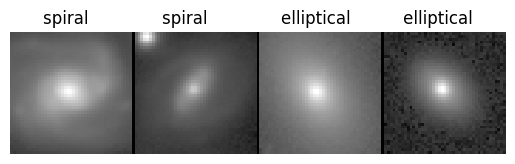

In [166]:
plot_images(image_test,target_test,c_test_pred,[12,13,14,15],prediction2=x_test_pred[:,0],scale=0.25)

Still rather clear that the classes are usually correct, but it gets less clear. The missclassified spiral in xgboost are now often relatively large with elongation or unusual features and with not so clear features as ring. Elliptical seem more often rather elongated also. 

Now I am comparing the two networks. Again the listed ones means agreement between convolutional network and targets and disagreement for the perceptron.

(3150, 2) 3150


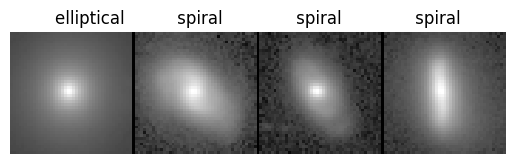

In [167]:
 plot_images(image_test,target_test,c_test_pred,[0,1,2,3],prediction2=m_test_pred,scale=0.25)

(3150, 2) 3150


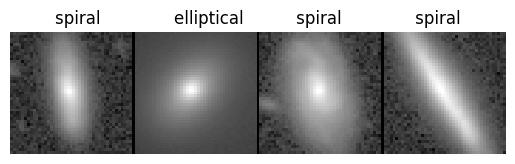

In [168]:
 plot_images(image_test,target_test,c_test_pred,[4,5,6,7],prediction2=m_test_pred,scale=0.25)

(3150, 2) 3150


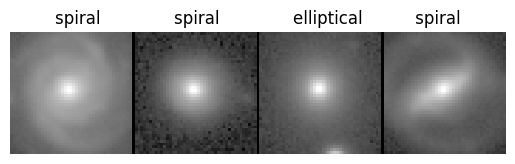

In [169]:
 plot_images(image_test,target_test,c_test_pred,[8,9,10,11],prediction2=m_test_pred,scale=0.25)
    #second is not clear spiral per eye

(3150, 2) 3150


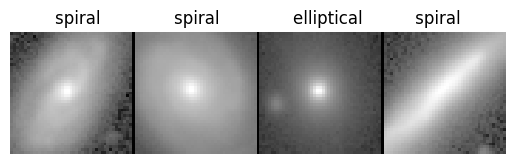

In [170]:
plot_images(image_test,target_test,c_test_pred,[12,13,14,15],prediction2=m_test_pred,scale=0.25)

While very few here are doubtful classifications of galaxies, many are not. Most missclassification seem spirals a to be expected because of the confusion matrix. Many seems rather nice looking face on spirals. Possible they are so rare in the traning set that when not all neighboring pixels are used together they are difficult  to recognize.  

Now looking on the ones not right by convolutional network. 

(3150, 2) 3150


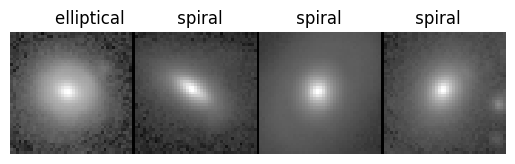

In [180]:
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],single=True,scale=0.25)
#last doubtful per eye, maybe also first

(3150, 2) 3150


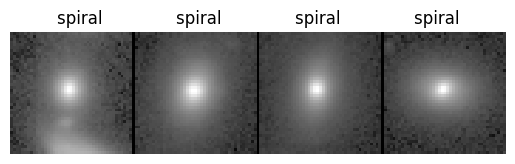

In [181]:
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],single=True,scale=0.25)
#all doubtful per eye but depends on scale and zoom

(3150, 2) 3150


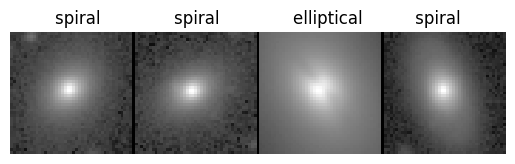

In [182]:
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],single=True,scale=0.25)
#one two and 3 doubful per eye

(3150, 2) 3150


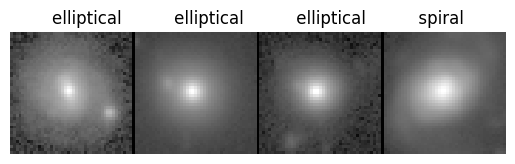

In [176]:
plot_images(image_test,target_test,c_test_pred,[12,13,14,15],single=True,scale=0.25)
#first doubtful per eye

Most are difficult per eye. While it is possible for some the features are outsiude the used window, it is unlikely. It is also posisble that are truly missclassified, since this classification was done by different citizen scientist and is thus not homogenous. It also used less deep data, thus when here very weak feature are visisble they were likely not visisble in the original images. 

Lets look on some of the clearest miss classifications. 

In [185]:
c=0
for i in range(len(x_test_pred)):
    if (c_test_pred[i])-target_test[i]>0.96:
        print(i)
        c+=1
print(c)  

401
942
1002
1460
1540
1590
1738
2564
2709
9


perceptron: probability for spiral 0.98391
convolutional: probability for spiral 0.94311
xgboost: probability for spiral 0.9975299835205078
logistic: probability for spiral 0.85551


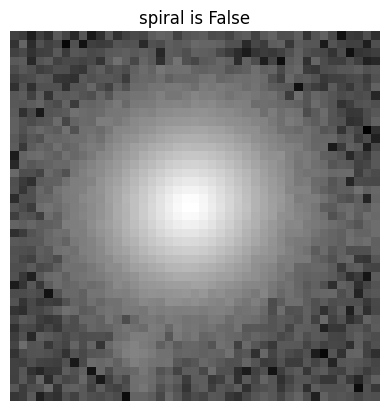

In [183]:
ids=401
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#looks not like a spiral

perceptron: probability for spiral 0.95363
convolutional: probability for spiral 0.99736
xgboost: probability for spiral 0.8718400001525879
logistic: probability for spiral 0.90539


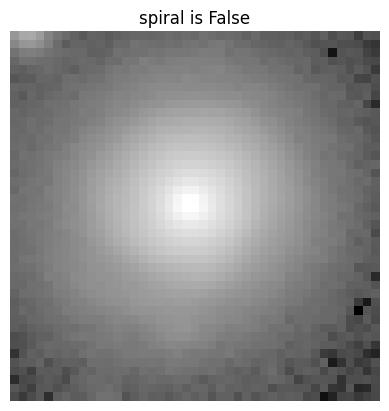

In [188]:
ids=942
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#maybe there is spiral at least it is large 

perceptron: probability for spiral 0.98391
convolutional: probability for spiral 0.99996
xgboost: probability for spiral 0.674239993095398
logistic: probability for spiral 0.93193


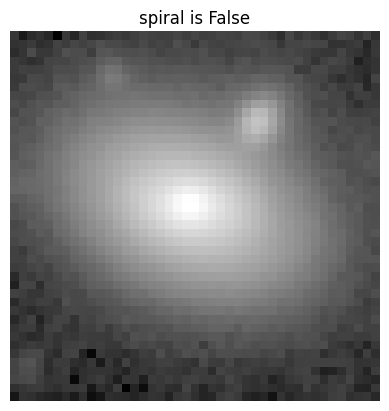

In [189]:
ids=1002
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#looks not spiral second source confuses 

perceptron: probability for spiral 1.0
convolutional: probability for spiral 0.96745
xgboost: probability for spiral 0.6703000068664551
logistic: probability for spiral 0.79671


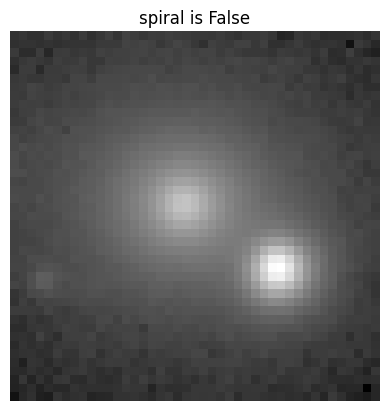

In [190]:
ids=1460
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#looks not like spiral, right second source (star) makes it difficult , better ignored by not networks 

perceptron: probability for spiral 0.99585
convolutional: probability for spiral 0.99443
xgboost: probability for spiral 0.053040001541376114
logistic: probability for spiral 0.10154


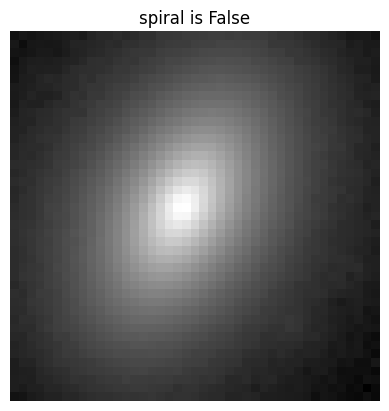

In [191]:
ids=1540
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#looks not like spiral, here not networrks are btter but they get other asymetric often wrong 

perceptron: probability for spiral 0.87691
convolutional: probability for spiral 0.98604
xgboost: probability for spiral 0.9966999888420105
logistic: probability for spiral 0.99481


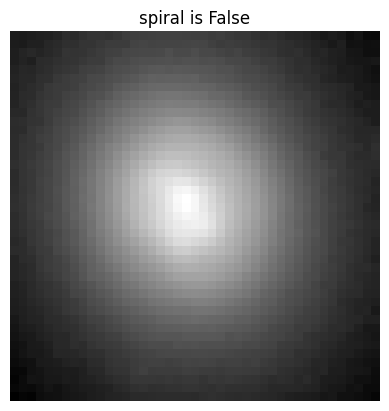

In [192]:
ids=1590
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#could be spiral, or is onkly center different? 

perceptron: probability for spiral 0.64379
convolutional: probability for spiral 1.0
xgboost: probability for spiral 0.03240000084042549
logistic: probability for spiral 0.34942


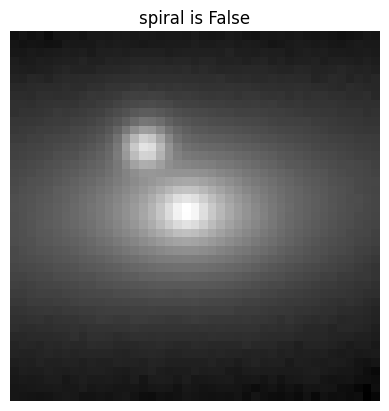

In [193]:
ids=1738
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#again second source causes problems, is better ignored by non networks 

perceptron: probability for spiral 0.12699
convolutional: probability for spiral 0.98844
xgboost: probability for spiral 0.04334000125527382
logistic: probability for spiral 0.70364


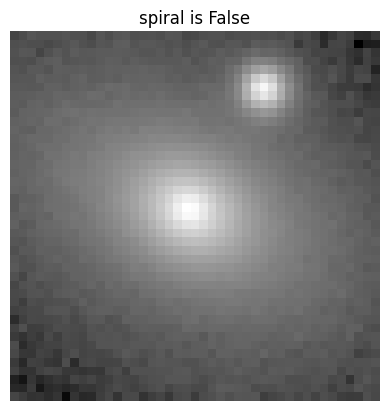

In [194]:
ids=2564
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#looks not like spiral, again bright star problem evenm further, only a problem in convolutional and weaker ectend logistic 

perceptron: probability for spiral 0.98391
convolutional: probability for spiral 0.96065
xgboost: probability for spiral 0.988860011100769
logistic: probability for spiral 0.98714


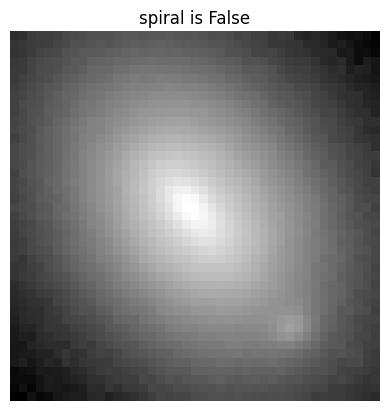

In [195]:
ids=2709
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#per eye less clear, some second source could contribute to confusion

It looks similar to the strongest missclassification some are likely a differnt class than assigned. Others are only wrong by some algorithm. Somewhat surprising is  convolutional more affected by bright neghbording sources than others. That could also be an slection effect, since we did not look on strong missclassification of others. 

In [199]:
c=0
for i in range(len(x_test_pred)):
    if (m_test_pred[i])-target_test[i]>0.96:
        print(i)
        c+=1
print(f"{c} strong miss classications")  

0
401
737
944
1002
1185
1371
1384
1460
1468
1540
1689
1860
2065
2162
2491
2619
2709
2721
2941
2997
21 strong miss classications


In [203]:
c=0
for i in range(len(x_test_pred)):
    if (x_test_pred[i,1])-target_test[i]>0.96:
        print(i)
        c+=1
print(f"{c} strong miss classifications")  

0
331
401
538
569
732
997
1096
1185
1384
1590
1838
1860
1937
1952
2008
2010
2388
2491
2619
2635
2709
2941
3118
24 strong miss classifications


perceptron: probability for spiral 0.31738
convolutional: probability for spiral 0.51082
xgboost: probability for spiral 0.9791100025177002
logistic: probability for spiral 0.92437


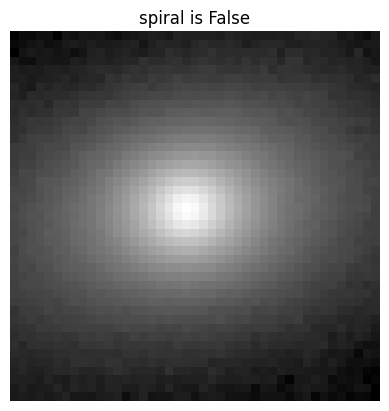

In [205]:
ids=3118
plt.axis('off')
plt.title(f"spiral is {bool(target_test[ids])}")
plt.imshow(abs(image_test[ids,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')
print(f"perceptron: probability for spiral {np.round(m_test_pred[ids],5)}")
print(f"convolutional: probability for spiral {np.round(c_test_pred[ids],5)}")
print(f"xgboost: probability for spiral {np.round(x_test_pred[ids,1],5)}")
print(f"logistic: probability for spiral {np.round(l_test_pred[ids,1],5)}")
#probably not spiral per eye

In [206]:
c=0
for i in range(len(x_test_pred)):
    if (l_test_pred[i,1])-target_test[i]>0.96:
        print(i)
        c+=1
print(f"{c} strong miss classications")  
#not so many but usually not certain clasisfication 

266
334
446
474
636
1096
1384
1590
2709
2982
10 strong miss classications


On the sky the orientation of images is menaingless. Thus, a simple methods tom imncrease the traing set is to add rotated and mirrored versions. That adds 7 more cases for our quadratic image. 

I first I create a function which creates the seven other options for one input image.


In [ ]:
def get_rot_mirror_square(dat):
    if dat.shape[0]!=dat.shape[1]:
        print("Data is not a square")
    else:
        res=np.zeros((8,dat.shape[0],dat.shape[1]))
        res[0,:,:]=dat
        res[4,:,:]=np.flip(dat,0)
        for i in range(3):
            res[1+i,:,:]=np.rot90(dat,k=i+1,axes=(0,1))
            res[5+i,:,:]=np.rot90(res[4,:,:],k=i+1,axes=(0,1))
        return res  

For testing I first show the orional version and then some results of application. 

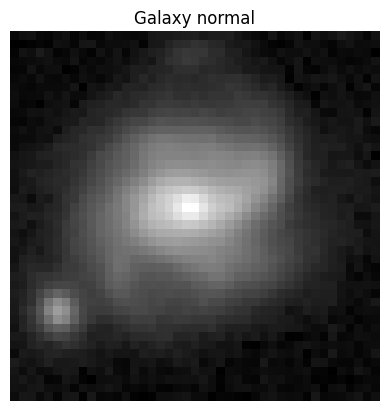

In [44]:
all_rots=get_rot_mirror_square(image_train[2,0,:,:])
plt.axis('off')
plt.title("Galaxy")
plt.imshow(abs(all_rots[0,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

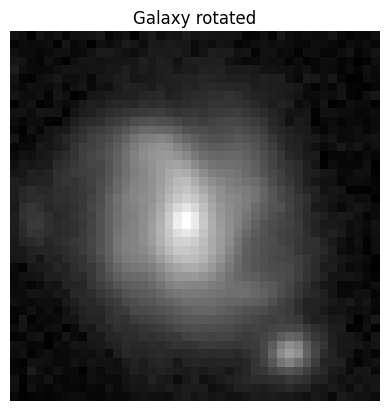

In [45]:
plt.axis('off')
plt.title("Galaxy rotated")
plt.imshow(abs(all_rots[1,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

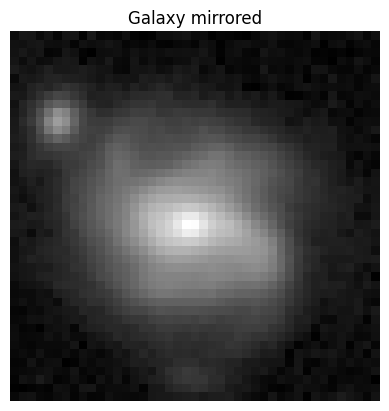

In [46]:
plt.axis('off')
plt.title("Galaxy mirrored")
plt.imshow(abs(all_rots[4,:,:])**0.5,cmap=cm.gray, interpolation='nearest')

Adding mirror versions of images.

In [214]:
#input image cube, feauture for them 
def  get_rot_mirror_all(image, target):
    image_all=np.zeros((image.shape[0]*8,1,image.shape[2],image.shape[3]))
    new_targ=[]
    for i in range(image.shape[0]):
        image_all[0+i*8:8+8*i,0,:,:]=get_rot_mirror_square(image_train[i,0,:,:])
        for j in range(8):
            new_targ.append(target[i])
    #maybe shuffle better?
    return image_all,new_targ        

In [215]:
rot_image_train,rot_target_train=get_rot_mirror_all(image_train,target_train)

In [217]:
rot_image_test,rot_target_test=get_rot_mirror_all(image_test,target_test)